## Convolutional autoencoder



Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [2]:
import os
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import glob
import cv2 as cv
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [3]:
import glob
import cv2 as cv

path = glob.glob("./roof_images/*.jpg")
cv_img = []
for img in path:
    n = cv.imread(img)
    cv_img.append(n)

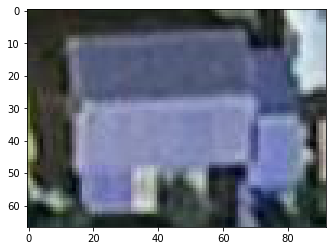

In [4]:
plt.imshow(cv_img[1000])

In [4]:
## Using resized images

In [5]:
import glob
import cv2 as cv

path = glob.glob("E:/alaki/resized/roof_images/*.jpg")
resized_images = []
for img in path:
    n = cv.imread(img)
    resized_images.append(n)

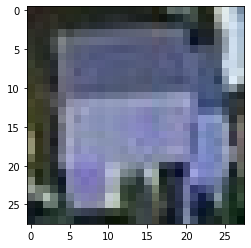

In [6]:
plt.imshow(resized_images[1000])

In [10]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 3))  


x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)



decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0   

In [7]:
import numpy as np
resized_images=np.array(resized_images)


In [8]:
x_train, x_test = train_test_split(resized_images, test_size=0.30)

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 3))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 3)) 

Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

tensorboard --logdir=/tmp/autoencoder



Then let's train our model. In the callbacks list we pass an instance of the TensorBoard callback. After every epoch, this callback will write logs to /tmp/autoencoder, which can be read by our TensorBoard server

In [12]:


H=autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='\\tmp\\autoencoder')])

Train on 29931 samples, validate on 12828 samples
Epoch 1/50
29931/29931 [==============================] - 284s 9ms/step - loss: 0.6345 - val_loss: 0.6164
Epoch 2/50
29931/29931 [==============================] - 279s 9ms/step - loss: 0.6170 - val_loss: 0.6120
Epoch 3/50
29931/29931 [==============================] - 277s 9ms/step - loss: 0.6124 - val_loss: 0.6113
Epoch 4/50
29931/29931 [==============================] - 276s 9ms/step - loss: 0.6095 - val_loss: 0.6064
Epoch 5/50
29931/29931 [==============================] - 274s 9ms/step - loss: 0.6072 - val_loss: 0.6043
Epoch 6/50
29931/29931 [==============================] - 276s 9ms/step - loss: 0.6039 - val_loss: 0.6010
Epoch 8/50
29931/29931 [==============================] - 276s 9ms/step - loss: 0.6028 - val_loss: 0.6015
Epoch 9/50
29931/29931 [==============================] - 275s 9ms/step - loss: 0.6018 - val_loss: 0.5999
Epoch 10/50
29931/29931 [==============================] - 273s 9ms/step - loss: 0.6007 - val_loss: 0.

In [13]:
decoded_imgs = autoencoder.predict(x_test)


<function matplotlib.pyplot.show(*args, **kw)>

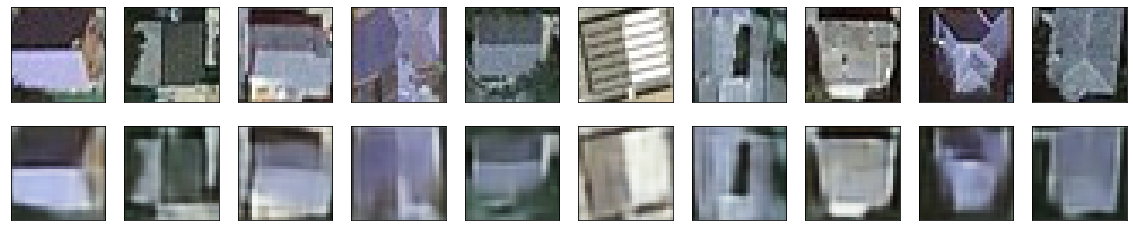

In [14]:

import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show

average cross-entropy = 0.57128274
average cross-entropy = 0.57042587
average cross-entropy = 0.6140865
average cross-entropy = 0.6595593
average cross-entropy = 0.6108479
average cross-entropy = 0.58195466
average cross-entropy = 0.62981904
average cross-entropy = 0.5630053
average cross-entropy = 0.5550866
average cross-entropy = 0.59696513


<function matplotlib.pyplot.show(*args, **kw)>

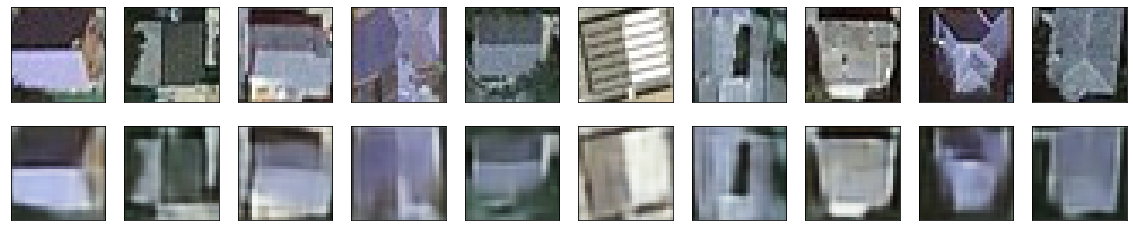

In [15]:

import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    print("average cross-entropy =", np.mean(tf.losses.binary_crossentropy(x_test[i], decoded_imgs[i])))
    
    
    
plt.show

In [16]:
for lll in range(len(x_test)):
    print(np.mean(tf.losses.binary_crossentropy(x_test[lll], decoded_imgs[lll])))
    
    

0.57128274
0.57042587
0.6140865
0.6595593
0.6108479
0.58195466
0.62981904
0.5630053
0.5550866
0.59696513
0.6301545
0.6063643
0.6255027
0.59667075
0.6410561
0.60427433
0.54342186
0.58626205
0.60756046
0.60004985
0.6192869
0.61619145
0.57598495
0.60033643
0.5594833
0.5969129
0.58630264
0.50578475
0.61150783
0.6529289
0.59119666
0.575578
0.59674704
0.6097455
0.56997204
0.55905175
0.5793985
0.62197095
0.5225634
0.66298926
0.6252375
0.6260399
0.59861094
0.59700096
0.5950197
0.5332866
0.5692843
0.60696596
0.6279617
0.5704706
0.5885412
0.56417
0.5993589
0.64988804
0.5707469
0.55959225
0.55846626
0.57754153
0.6022885
0.6133444
0.502929
0.6169554
0.60705566
0.5584912
0.49562955
0.60698503
0.59745413
0.6380121
0.6083316
0.57712877
0.6113159
0.56255186
0.64171094
0.4124339
0.6263202
0.65981466
0.6470035
0.59257346
0.60922706
0.6304729
0.6432177
0.591671
0.5536413
0.6101769
0.5920569
0.5680033
0.62999195
0.60116225
0.60573786
0.64765584
0.59394264
0.60822594
0.60654986
0.61404145
0.63012487
0.6036

0.6285289
0.6269487
0.57930595
0.62927747
0.61371225
0.63288486
0.6074834
0.6337348
0.6149912
0.5499219
0.5800497
0.5953552
0.6157365
0.5930334
0.5972782
0.5847625
0.5629429
0.59078115
0.6045988
0.5747966
0.56986827
0.6127915
0.6248088
0.5641963
0.57062167
0.6214604
0.63222814
0.5732238
0.62151444
0.649973
0.600578
0.6018574
0.5662166
0.61421996
0.601168
0.59099215
0.6217178
0.54522765
0.6200354
0.56874514
0.5601394
0.55943537
0.6499931
0.5493685
0.6046447
0.61285543
0.58531463
0.6082937
0.59306014
0.63914955
0.58563054
0.54660803
0.6168657
0.47238073
0.62891436
0.60017705
0.6200478
0.5995171
0.5361377
0.6323971
0.6017422
0.6603496
0.61108
0.5993177
0.6690137
0.60806084
0.62410504
0.6389892
0.5825916
0.5669918
0.63829136
0.5548848
0.6225012
0.51017326
0.5486206
0.5836711
0.61194915
0.5859883
0.61194044
0.6253678
0.50828755
0.49115542
0.6442357
0.6180985
0.5761192
0.6004609
0.57416004
0.59672326
0.60854113
0.59861124
0.5613092
0.61027193
0.52945226
0.5874492
0.59127116
0.64917386
0.6226

0.62888134
0.54722154
0.5352302
0.6075193
0.6121424
0.45662323
0.61774355
0.62618774
0.5679748
0.6077075
0.58712965
0.43066207
0.5441714
0.55684847
0.60993755
0.6190786
0.5629826
0.5786845
0.61607724
0.537166
0.55862904
0.5974231
0.56088084
0.63766277
0.608925
0.64492106
0.5107991
0.6200353
0.40267783
0.58396596
0.6178324
0.60715306
0.62000614
0.6003886
0.60946476
0.5536787
0.5925866
0.611351
0.5690546
0.6222452
0.6055685
0.63293093
0.60773367
0.60777503
0.54644346
0.6127715
0.57116437
0.5816491
0.565485
0.61411315
0.6257167
0.53182065
0.55525887
0.54239047
0.49128225
0.656395
0.641297
0.60932946
0.5676157
0.6600313
0.61366177
0.6678854
0.59371424
0.5940036
0.58411276
0.5661534
0.5808142
0.64096594
0.54366326
0.5860302
0.5814271
0.5689336
0.60365605
0.645868
0.5623568
0.60869545
0.6314329
0.5689076
0.6276172
0.5883011
0.5748523
0.56365997
0.6384344
0.6017101
0.64916754
0.6081695
0.5859184
0.5829687
0.63672066
0.5667171
0.67684025
0.38097635
0.59668976
0.6502897
0.6025245
0.60394067
0.5

0.605606
0.5979373
0.66493684
0.5954411
0.5754459
0.5264429
0.5728213
0.5731584
0.39879897
0.58572686
0.66048354
0.61210513
0.60290307
0.6576043
0.6498914
0.5945009
0.58288026
0.62089014
0.5658841
0.60947824
0.6348873
0.59735537
0.54342186
0.6083362
0.633477
0.5875538
0.6359458
0.5860733
0.6000227
0.5684301
0.6184335
0.60492635
0.58585054
0.6089356
0.629757
0.61128867
0.5795818
0.6172104
0.6313116
0.5599446
0.62358826
0.61553323
0.5687389
0.58193034
0.56230253
0.56893396
0.5851394
0.6201777
0.61997646
0.59940904
0.58119786
0.5588906
0.56480986
0.5547578
0.59525204
0.57398367
0.52848977
0.60295707
0.6066564
0.5998149
0.55900526
0.643591
0.53483075
0.64216805
0.5976598
0.56179774
0.6029372
0.45462176
0.59010166
0.62824905
0.6304755
0.62007827
0.58636063
0.5441547
0.5844139
0.59865093
0.59990865
0.6108731
0.6452562
0.40763342
0.5767579
0.6166393
0.62575686
0.5508824
0.5616378
0.5710049
0.54781955
0.59806085
0.62076247
0.5765398
0.5306302
0.5784793
0.5353019
0.65797025
0.5506939
0.62745726

0.5766549
0.59549785
0.6123701
0.59233016
0.6313718
0.561399
0.5728142
0.5463481
0.60764986
0.6056683
0.5426467
0.5914797
0.60077673
0.6057945
0.66280395
0.6098195
0.59605277
0.59892166
0.38753548
0.5886694
0.56940484
0.5626502
0.48967892
0.57933384
0.61756337
0.59919226
0.6032779
0.5264827
0.64055043
0.51293993
0.61861974
0.61582893
0.5357485
0.6162148
0.6396382
0.62250984
0.57607067
0.57161427
0.65501827
0.585985
0.5874797
0.60133356
0.5376419
0.54134244
0.6490663
0.6013595
0.6634006
0.5894277
0.63817054
0.6664085
0.6083047
0.5081904
0.5582792
0.6619168
0.60091037
0.60164547
0.59275675
0.6382808
0.57197994
0.56361973
0.61978537
0.6543602
0.61752343
0.6502007
0.6243238
0.55720013
0.5482795
0.61980844
0.5794989
0.5873215
0.60128295
0.6127137
0.6186543
0.44499776
0.3896703
0.51706296
0.56604004
0.4404476
0.5234629
0.5726168
0.54989266
0.57256365
0.6551616
0.6267406
0.5964457
0.5829571
0.6289503
0.60407877
0.58757687
0.5932168
0.66976273
0.54845065
0.5805972
0.54101455
0.47605422
0.60678

0.4715631
0.53469044
0.5693398
0.6443558
0.62504894
0.59760916
0.5472082
0.6428228
0.48109654
0.62993026
0.6449036
0.66080177
0.61918783
0.6181874
0.6505185
0.55814594
0.58267206
0.6294144
0.6191976
0.5401744
0.60641485
0.6158216
0.6325953
0.5792638
0.6148516
0.59290904
0.59429044
0.6188181
0.6114961
0.59418637
0.615306
0.6327111
0.60355943
0.5714721
0.37407917
0.6082247
0.60275245
0.43499258
0.650054
0.630813
0.6114088
0.6082214
0.55987054
0.6046679
0.6095266
0.58383846
0.4996515
0.5832922
0.59694976
0.6136714
0.60844564
0.63994575
0.6213148
0.578603
0.6173507
0.549249
0.5939193
0.61435646
0.58608586
0.6366167
0.5977318
0.3896703
0.6238713
0.62063473
0.6274316
0.5327385
0.5311195
0.61496425
0.6036446
0.6011806
0.55092436
0.5763164
0.619853
0.6212584
0.6512463
0.613328
0.59658235
0.55159336
0.5600048
0.61566055
0.55260307
0.3889086
0.5986331
0.6096432
0.6174077
0.5629551
0.57159567
0.5960916
0.57902646
0.6575542
0.59209794
0.6458801
0.6413534
0.58463126
0.63860136
0.65108645
0.5709446


0.57753134
0.5553849
0.49060604
0.58501923
0.568422
0.5886447
0.4413269
0.50943387
0.6179723
0.6562004
0.64431965
0.62542367
0.59100044
0.5461752
0.49427685
0.5969086
0.5843503
0.6137785
0.5442925
0.633886
0.56427455
0.63209563
0.5863502
0.57405216
0.60092413
0.6118987
0.63246596
0.5622623
0.5274655
0.5621681
0.6111587
0.6314955
0.62955713
0.6209695
0.5527807
0.6146998
0.61794376
0.5541239
0.63724005
0.5961489
0.5986848
0.52838945
0.4067604
0.54775786
0.61067635
0.61727905
0.6134098
0.6396736
0.5706589
0.59869736
0.51565343
0.5649078
0.6045425
0.630753
0.63473564
0.60018814
0.6460362
0.6242306
0.56058496
0.5914943
0.60394067
0.6395698
0.6255489
0.58384246
0.5642446
0.53649515
0.6117804
0.53648305
0.6239706
0.6111429
0.5853616
0.6019183
0.6028122
0.5808759
0.651526
0.6220154
0.6053092
0.57493
0.64264673
0.5956439
0.57513106
0.61423635
0.57154983
0.5042476
0.53360224
0.6006973
0.5930221
0.5678598
0.6046906
0.61346084
0.61076427
0.6027624
0.6408542
0.619131
0.6207064
0.63993764
0.58582336

0.5984504
0.5864136
0.57101667
0.5742401
0.6420413
0.5606435
0.6375977
0.35476506
0.5508467
0.6339275
0.6144893
0.592952
0.5835539
0.61555177
0.57841974
0.47898543
0.5998852
0.6111886
0.51477146
0.60333157
0.6188132
0.63243747
0.65797025
0.5453966
0.51395565
0.55225736
0.58665705
0.564182
0.5986208
0.5808184
0.60293394
0.61975944
0.6510278
0.6268197
0.5901538
0.609118
0.6139358
0.6193022
0.61734223
0.6252446
0.6113088
0.57727015
0.5456016
0.5691775
0.5422743
0.5812212
0.60095173
0.56629276
0.6435637
0.62655276
0.6130738
0.5304809
0.5811538
0.61498356
0.61508703
0.5811485
0.57397914
0.5552098
0.60543555
0.5610985
0.55395895
0.5845268
0.6384779
0.54381007
0.5605783
0.5910354
0.5893942
0.62654245
0.6208662
0.5969555
0.6150971
0.6173452
0.6370842
0.62377477
0.59677154
0.58603615
0.58342457
0.6166915
0.6100332
0.5649638
0.5634108
0.6030194
0.5383401
0.5732879
0.54855216
0.6519296
0.5864699
0.6308221
0.6686206
0.60067797
0.5428813
0.65043783
0.6308012
0.5994458
0.5521169
0.45347464
0.6321756

0.5391873
0.6423741
0.581411
0.61996037
0.5543806
0.5942362
0.58188725
0.62510663
0.60544324
0.58745277
0.6265254
0.594693
0.6202832
0.6178651
0.5765723
0.51125187
0.6157384
0.64641845
0.5174144
0.6660284
0.6169046
0.54234016
0.6121134
0.5057556
0.5627696
0.57568455
0.58330095
0.5943366
0.57029796
0.61381793
0.6080491
0.56734496
0.57821536
0.6011754
0.5857606
0.5517187
0.56844914
0.62828374
0.51857424
0.62299556
0.6108078
0.55749583
0.42262283
0.61112905
0.5872864
0.60818815
0.6094123
0.6034965
0.6524683
0.588133
0.5506558
0.5925755
0.62717575
0.58411103
0.6112088
0.58967435
0.5882914
0.59389466
0.5660514
0.5968901
0.64577174
0.596961
0.557815
0.6237442
0.6032287
0.62972975
0.6259258
0.5642431
0.39846078
0.5867287
0.62037253
0.5806061
0.60370845
0.61763394
0.62332606
0.31545433
0.55570656
0.6191173
0.5658
0.526287
0.65985435
0.5786209
0.5192039
0.651472
0.40107676
0.60657936
0.61238444
0.5795644
0.5754346
0.57938427
0.5972429
0.62527037
0.6265736
0.6340466
0.5840345
0.57905275
0.624185

0.55206627
0.59770846
0.6226912
0.5852302
0.618075
0.6272906
0.6279617
0.5964978
0.60974807
0.57287323
0.60082346
0.62222487
0.6192899
0.573229
0.6016059
0.55457413
0.54182124
0.628142
0.57678163
0.5938857
0.6567973
0.5992281
0.5502534
0.63917196
0.60643446
0.58655965
0.63017166
0.5714222
0.5950976
0.50492114
0.60115707
0.6334319
0.6246238
0.35434842
0.64330477
0.6111654
0.6133749
0.60786
0.5787966
0.616189
0.5340947
0.5527615
0.5576333
0.5742149
0.59963197
0.6023891
0.59715664
0.527463
0.6358482
0.5743368
0.60945386
0.59453106
0.56171143
0.5965789
0.58348715
0.62658846
0.51754916
0.6454167
0.6412897
0.52656376
0.62995756
0.6281744
0.5687814
0.60887927
0.60947824
0.62755233
0.6644739
0.59444845
0.60477227
0.6212924
0.6119143
0.6529063
0.5833983
0.61473036
0.6349762
0.61870086
0.5258257
0.6073887
0.5918103
0.61060566
0.6662269
0.59159434
0.38478634
0.51619065
0.6116329
0.6110997
0.6397052
0.5881675
0.6298885
0.5956135
0.626891
0.5586614
0.58443266
0.5914193
0.5814985
0.6428861
0.5780625

0.5693009
0.5640761
0.5562359
0.6393433
0.57938516
0.63802564
0.575726
0.62316793
0.6050033
0.6396947
0.600145
0.6012569
0.55401874
0.63777894
0.5999529
0.5961819
0.6341099
0.5977763
0.61434233
0.59851617
0.58699715
0.41160795
0.5896731
0.60697925
0.58013374
0.62146884
0.6018044
0.5248809
0.6338891
0.60614604
0.5921635
0.61236197
0.5845629
0.5615116
0.5973455
0.5817935
0.5705755
0.59195095
0.6281569
0.6107102
0.6420075
0.57634896
0.58013105
0.65408045
0.5673449
0.5888594
0.5749242
0.5475032
0.5837271
0.6090133
0.5828297
0.5501996
0.60531306
0.6124399
0.6234757
0.58734006
0.6023175
0.61464864
0.61572844
0.59160125
0.57049733
0.590436
0.60842663
0.31828427
0.5996629
0.5966557
0.6365492
0.6617553
0.6507733
0.63900113
0.6409792
0.61587924
0.61048526
0.5858489
0.5901587
0.65107816
0.59854126
0.56158036
0.6413808
0.54443944
0.4960277
0.58715624
0.5561533
0.5897008
0.5773172
0.5482498
0.6161188
0.61079466
0.6545572
0.5855288
0.64784384
0.5584823
0.60473794
0.61428654
0.5396166
0.6238157
0.591

0.6046785
0.55900997
0.56243896
0.55571
0.56529737
0.6464999
0.5670676
0.59322846
0.58505374
0.63457066
0.622072
0.5742353
0.56578493
0.601434
0.5768073
0.5971656
0.5652909
0.669089
0.61877996
0.53407335
0.58517313
0.57067925
0.62262696
0.62755436
0.57034147
0.60669464
0.6534934
0.547835
0.6252701
0.5657647
0.5597405
0.62633115
0.54849213
0.5918348
0.60593116
0.60295606
0.5922007
0.6012134
0.5641787
0.6014272
0.61142707
0.56442195
0.6594853
0.6301428
0.56106746
0.6269459
0.60091275
0.6222747
0.6203728
0.6089763
0.3046234
0.5136811
0.6310346
0.5488901
0.59822357
0.52607864
0.6186219
0.5655873
0.6067807
0.5616494
0.539175
0.6088002
0.64289063
0.5996464
0.63050336
0.61904037
0.63281965
0.60830545
0.58682835
0.5749663
0.60863096
0.62649226
0.57784784
0.59949195
0.6208735
0.63345355
0.6106196
0.60237706
0.6387161
0.638631
0.610033
0.56514543
0.59459984
0.66168946
0.60385007
0.59630543
0.5767338
0.6169554
0.6298043
0.58909994
0.57905114
0.65540624
0.5887958
0.6101469
0.617551
0.63295126
0.30

0.6246536
0.6104548
0.61689776
0.64482623
0.5942288
0.5876253
0.6086425
0.60979944
0.5122368
0.58126783
0.5287886
0.6383079
0.5715002
0.6266231
0.62021357
0.5736864
0.5981585
0.47638312
0.588971
0.61641765
0.6195856
0.6103257
0.62184423
0.6375214
0.5363947
0.6052332
0.5418904
0.5964457
0.55741704
0.6231021
0.5482312
0.6145264
0.57353616
0.5989368
0.62503296
0.59646946
0.617435
0.60803384
0.5613609
0.39719832
0.61419404
0.6554176
0.5082436
0.59620386
0.6503569
0.6485954
0.61043847
0.6405017
0.6038628
0.600721
0.59818214
0.6054569
0.59557503
0.58077455
0.5461059
0.62959766
0.6266263
0.66771275
0.58128417
0.6121892
0.53704053
0.560493
0.6025757
0.52271783
0.5811224
0.56531
0.5151971
0.6337876
0.6034674
0.5907366
0.43198597
0.63035667
0.5828472
0.6027099
0.6135015
0.6313718
0.565332
0.60722744
0.61330485
0.5839996
0.5598946
0.623065
0.6053853
0.6101753
0.61916864
0.59123665
0.60567373
0.5484317
0.5103901
0.5918728
0.50247985
0.61105865
0.64614666
0.57735395
0.6558459
0.60058475
0.61628705


0.5678199
0.64801264
0.65001154
0.59063745
0.6332252
0.6087168
0.61335796
0.61047065
0.607716
0.62532467
0.62827104
0.6014507
0.59900033
0.6428285
0.62347007
0.64597106
0.64113075
0.60421264
0.6368549
0.58341163
0.5058199
0.62126714
0.5688061
0.5602741
0.56763077
0.58348525
0.5834766
0.59163994
0.6306031
0.65623254
0.6108554
0.6149459
0.52868193
0.6106455
0.56631655
0.568808
0.51576275
0.60290915
0.6251761
0.5544094
0.6037568
0.5467337
0.6453133
0.66400725
0.5649149
0.57681423
0.60549766
0.57807547
0.63125795
0.6262451
0.57360935
0.58501935
0.5951001
0.61938536
0.5684443
0.636381
0.53901076
0.6225743
0.6352195
0.6048098
0.60177374
0.59767944
0.65239894
0.51106614
0.6114394
0.6178413
0.61020106
0.594943
0.66586477
0.578211
0.51403755
0.55639577
0.59233916
0.6170636
0.62267435
0.60950947
0.5774412
0.58848953
0.6147465
0.5922244
0.64400005
0.56667554
0.60781556
0.5743445
0.47465718
0.60581315
0.61731523
0.603807
0.5868699
0.55595547
0.41326624
0.5932959
0.60391253
0.56811
0.5652566
0.5249

0.6203835
0.54333735
0.5467623
0.5672028
0.5510079
0.6056489
0.5896755
0.63067114
0.57727426
0.60165405
0.5640211
0.5886864
0.6337216
0.5840595
0.5276516
0.6311992
0.56917477
0.6193418
0.5494759
0.6071447
0.56011057
0.5756164
0.60494924
0.60022104
0.6217994
0.50292575
0.60489416
0.59723073
0.5547907
0.5747942
0.57108057
0.6118224
0.5864956
0.5949443
0.59940904
0.65041834
0.56547993
0.6316094
0.6310747
0.6248832
0.60861295
0.5860207
0.6101902
0.6037451
0.5343285
0.56963366
0.60559464
0.61200047
0.5111499
0.61529
0.61814225
0.6097323
0.58754724
0.6524681
0.5846675
0.5788236
0.59627604
0.51548594
0.6014513
0.59303606
0.5958765
0.6739916
0.60435283
0.5299855
0.6239308
0.6088042
0.61056143
0.6309764
0.5609425
0.567818
0.57071066
0.6617553
0.5560447
0.6077365
0.5244193
0.617531
0.60769224
0.6243238
0.64151734
0.47686014
0.62127715
0.57101154
0.4858237
0.5668729
0.5809844
0.6159536
0.6068932
0.59042305
0.49896774
0.6416321
0.5638863
0.6042788
0.551708
0.5508293
0.5464926
0.54353935
0.59766763

0.6193569
0.61803216
0.5886006
0.6537401
0.6157888
0.5476268
0.6013163
0.6129508
0.5906828
0.54623085
0.59176564
0.59936076
0.6093012
0.55694056
0.6362846
0.5955391
0.5826307
0.59092736
0.6356408
0.6266419
0.60809565
0.61720234
0.62323105
0.55876
0.64133483
0.51610774
0.56513494
0.61818284
0.55351543
0.5854057
0.61955154
0.48367345
0.6431157
0.55866003
0.66204536
0.5789755
0.5406957
0.6164899
0.5820813
0.5999854
0.6244534
0.60012656
0.63408566
0.49125528
0.53674424
0.5803344
0.56559193
0.6178238
0.6143928
0.6165088
0.59134716
0.55815715
0.61126757
0.5954622
0.6179733
0.58554786
0.52613246
0.62202597
0.5876096
0.5670997
0.47106162
0.5658055
0.6128265
0.6337408
0.6189412
0.67120767
0.4432858
0.6014889
0.59600514
0.643437
0.635238
0.5120976
0.6218635
0.45413184
0.54369944
0.66124445
0.65552944
0.5882506
0.61974996
0.609703
0.62225103
0.5620603
0.61629504
0.49390426
0.51511514
0.6291338
0.6406199
0.5977839
0.64151263
0.51246065
0.61395204
0.63272536
0.66660154
0.57366
0.5762987
0.6095012
0

In [17]:
arr=[]


In [18]:

for lll in range(len(x_test)):
    
    arr.append(np.mean(tf.losses.binary_crossentropy(x_test[lll], decoded_imgs[lll])))

In [19]:
for jjj in range(len(arr)):
    print(arr[jjj])

0.57128274
0.57042587
0.6140865
0.6595593
0.6108479
0.58195466
0.62981904
0.5630053
0.5550866
0.59696513
0.6301545
0.6063643
0.6255027
0.59667075
0.6410561
0.60427433
0.54342186
0.58626205
0.60756046
0.60004985
0.6192869
0.61619145
0.57598495
0.60033643
0.5594833
0.5969129
0.58630264
0.50578475
0.61150783
0.6529289
0.59119666
0.575578
0.59674704
0.6097455
0.56997204
0.55905175
0.5793985
0.62197095
0.5225634
0.66298926
0.6252375
0.6260399
0.59861094
0.59700096
0.5950197
0.5332866
0.5692843
0.60696596
0.6279617
0.5704706
0.5885412
0.56417
0.5993589
0.64988804
0.5707469
0.55959225
0.55846626
0.57754153
0.6022885
0.6133444
0.502929
0.6169554
0.60705566
0.5584912
0.49562955
0.60698503
0.59745413
0.6380121
0.6083316
0.57712877
0.6113159
0.56255186
0.64171094
0.4124339
0.6263202
0.65981466
0.6470035
0.59257346
0.60922706
0.6304729
0.6432177
0.591671
0.5536413
0.6101769
0.5920569
0.5680033
0.62999195
0.60116225
0.60573786
0.64765584
0.59394264
0.60822594
0.60654986
0.61404145
0.63012487
0.6036

0.43949088
0.57623714
0.61434436
0.6254301
0.54941964
0.54404813
0.57375836
0.5774566
0.61133987
0.5985469
0.617959
0.64774317
0.60612684
0.6488406
0.5938418
0.57240367
0.53505933
0.5758038
0.628327
0.5534005
0.58885163
0.59666127
0.52298373
0.58243585
0.6176767
0.62013406
0.5769458
0.6493229
0.5880941
0.65761113
0.60325694
0.5697616
0.5803689
0.6560298
0.5599649
0.6080528
0.62725735
0.5949731
0.6452776
0.5825768
0.62897086
0.5830854
0.5545251
0.60622144
0.6257609
0.6162537
0.6149102
0.63898003
0.6326236
0.58703554
0.59717715
0.5895616
0.6473844
0.60597277
0.49213043
0.5978402
0.5332597
0.5517243
0.53352135
0.53983784
0.5241575
0.6543276
0.604587
0.62543714
0.55861324
0.5388744
0.6351044
0.60711294
0.56050056
0.59973633
0.58362603
0.60945886
0.62314343
0.5749956
0.5979047
0.61509746
0.62006354
0.5940624
0.5886936
0.61769134
0.609271
0.58240277
0.5946504
0.6183591
0.6495418
0.59433234
0.6090295
0.6211214
0.6589421
0.6088216
0.604435
0.5454688
0.63059074
0.5629827
0.5773925
0.6207591
0.5

0.6348873
0.59735537
0.54342186
0.6083362
0.633477
0.5875538
0.6359458
0.5860733
0.6000227
0.5684301
0.6184335
0.60492635
0.58585054
0.6089356
0.629757
0.61128867
0.5795818
0.6172104
0.6313116
0.5599446
0.62358826
0.61553323
0.5687389
0.58193034
0.56230253
0.56893396
0.5851394
0.6201777
0.61997646
0.59940904
0.58119786
0.5588906
0.56480986
0.5547578
0.59525204
0.57398367
0.52848977
0.60295707
0.6066564
0.5998149
0.55900526
0.643591
0.53483075
0.64216805
0.5976598
0.56179774
0.6029372
0.45462176
0.59010166
0.62824905
0.6304755
0.62007827
0.58636063
0.5441547
0.5844139
0.59865093
0.59990865
0.6108731
0.6452562
0.40763342
0.5767579
0.6166393
0.62575686
0.5508824
0.5616378
0.5710049
0.54781955
0.59806085
0.62076247
0.5765398
0.5306302
0.5784793
0.5353019
0.65797025
0.5506939
0.62745726
0.6547864
0.47148466
0.556149
0.63698065
0.6323631
0.6603637
0.5720515
0.51755023
0.63805413
0.5739447
0.6340417
0.65072405
0.65687734
0.5445162
0.6293395
0.5362253
0.583892
0.39782763
0.5576713
0.52823657
0

0.57932425
0.40201822
0.6362013
0.5737159
0.6006775
0.6004517
0.62264246
0.5351192
0.65377635
0.6644849
0.57753575
0.6023173
0.57741064
0.59106785
0.5909117
0.59534854
0.5907585
0.58783543
0.63013786
0.629878
0.48681867
0.58204037
0.6218495
0.62037355
0.614789
0.55593854
0.6312307
0.61586744
0.3934419
0.60820943
0.5976644
0.60444826
0.5140505
0.60323113
0.61015266
0.6329088
0.612961
0.63004375
0.5766602
0.5568296
0.6225522
0.5728147
0.51576114
0.58538455
0.6150287
0.62749785
0.6184334
0.63048935
0.58203256
0.5133198
0.5903938
0.5870108
0.60726833
0.61618036
0.60749185
0.62400115
0.5766142
0.5617335
0.5673221
0.6140905
0.5816699
0.614155
0.5471965
0.5187654
0.62755126
0.5252416
0.6083784
0.6061393
0.62431884
0.5878822
0.64102787
0.5189838
0.49261957
0.57522386
0.61195034
0.58065206
0.6099034
0.58419627
0.5330615
0.6184348
0.59427524
0.5928846
0.5862165
0.5831554
0.6079972
0.6622413
0.56525236
0.61263263
0.6007952
0.6032779
0.6269167
0.5465625
0.6289286
0.5867566
0.5366185
0.56488615
0.6

0.6281022
0.5552028
0.6064833
0.6225775
0.5767769
0.59659445
0.6090684
0.56859875
0.527374
0.5651168
0.6117329
0.5228853
0.62673616
0.60662085
0.60688025
0.59613913
0.6080276
0.5894711
0.5061407
0.61145943
0.62842613
0.5855616
0.6036856
0.4936237
0.5647243
0.6005648
0.66092813
0.59204376
0.6080318
0.6181393
0.59777933
0.58081555
0.6312637
0.5779849
0.62042856
0.58796734
0.5968663
0.46340838
0.4036557
0.6234431
0.5915025
0.6008725
0.60888994
0.5949653
0.61551505
0.51676506
0.5946092
0.61286294
0.605607
0.61336595
0.5627518
0.4676453
0.5610736
0.5978314
0.60979366
0.56273586
0.60229367
0.63972384
0.39846078
0.59528583
0.6050109
0.5694294
0.5438011
0.5844908
0.57958937
0.61717486
0.63975286
0.5753429
0.5776764
0.62537044
0.62921524
0.60813093
0.6245667
0.5937315
0.61663496
0.632372
0.5675817
0.62246335
0.5781537
0.57218474
0.62642854
0.5985284
0.60462767
0.5735042
0.63429064
0.497538
0.64587724
0.568118
0.55755925
0.5451929
0.6069501
0.27742514
0.5868644
0.5836959
0.60168135
0.6369552
0.6

0.55653435
0.65210885
0.61723435
0.61918455
0.61006236
0.60210043
0.5975385
0.6726954
0.50733346
0.54483414
0.5936396
0.63009673
0.551647
0.5967658
0.49749628
0.60182524
0.6258331
0.60871935
0.55242366
0.58912176
0.57369417
0.60806626
0.6152573
0.63434124
0.60994315
0.5949864
0.55900526
0.52502203
0.58328855
0.5540346
0.6128547
0.60399634
0.60533136
0.54987824
0.66086555
0.63333726
0.640535
0.6283984
0.6169793
0.58343136
0.57136685
0.6430035
0.6051577
0.6150233
0.63225126
0.5833084
0.5960628
0.62103057
0.59155303
0.56659997
0.5858569
0.56468093
0.6481972
0.6081868
0.56885433
0.6428599
0.61839175
0.59043425
0.5845471
0.5459317
0.62578434
0.575476
0.6325202
0.5870261
0.5822622
0.5900618
0.62603027
0.6197159
0.54690737
0.671584
0.58672047
0.4605738
0.55831546
0.64807916
0.6099469
0.5933874
0.60078627
0.5812276
0.6682612
0.58160293
0.6058615
0.6018809
0.64632034
0.63844293
0.59728736
0.6190917
0.641735
0.6075688
0.59381527
0.5929964
0.5999521
0.64210355
0.6139444
0.5753407
0.61532307
0.556

0.41482046
0.59060824
0.59080076
0.55395895
0.65153205
0.6260933
0.5884316
0.5717948
0.65058625
0.53052145
0.57976127
0.5687915
0.61431605
0.5733281
0.62031746
0.6457446
0.553536
0.55676264
0.57804847
0.60947824
0.5528224
0.6015308
0.5999756
0.6281026
0.6114761
0.60953647
0.5855626
0.5999539
0.5814723
0.5874822
0.6176855
0.60308933
0.61875033
0.6517074
0.56815815
0.6371822
0.576348
0.6304512
0.6404321
0.62737787
0.50373995
0.60890484
0.57988846
0.600379
0.53174436
0.62527585
0.5939122
0.62353384
0.53656095
0.5234011
0.6011398
0.56255716
0.4648292
0.60220987
0.531253
0.6400595
0.57980645
0.6103185
0.624074
0.5987446
0.31206512
0.60355335
0.57956237
0.57378346
0.619029
0.648412
0.5852971
0.6001789
0.61271214
0.60675114
0.66757125
0.62008584
0.5437492
0.6319811
0.611913
0.66052073
0.63597965
0.617115
0.60009223
0.58466464
0.5746908
0.5211068
0.5268168
0.6251761
0.60668916
0.5668582
0.6550305
0.5509305
0.5907852
0.62239665
0.5819466
0.5024219
0.62266064
0.5624942
0.6175265
0.5982707
0.6286

0.63917196
0.60643446
0.58655965
0.63017166
0.5714222
0.5950976
0.50492114
0.60115707
0.6334319
0.6246238
0.35434842
0.64330477
0.6111654
0.6133749
0.60786
0.5787966
0.616189
0.5340947
0.5527615
0.5576333
0.5742149
0.59963197
0.6023891
0.59715664
0.527463
0.6358482
0.5743368
0.60945386
0.59453106
0.56171143
0.5965789
0.58348715
0.62658846
0.51754916
0.6454167
0.6412897
0.52656376
0.62995756
0.6281744
0.5687814
0.60887927
0.60947824
0.62755233
0.6644739
0.59444845
0.60477227
0.6212924
0.6119143
0.6529063
0.5833983
0.61473036
0.6349762
0.61870086
0.5258257
0.6073887
0.5918103
0.61060566
0.6662269
0.59159434
0.38478634
0.51619065
0.6116329
0.6110997
0.6397052
0.5881675
0.6298885
0.5956135
0.626891
0.5586614
0.58443266
0.5914193
0.5814985
0.6428861
0.57806253
0.576642
0.6455127
0.58932465
0.6015751
0.5534343
0.57666624
0.590746
0.53619826
0.5988772
0.4777589
0.5539526
0.58876574
0.50795263
0.56859
0.61349696
0.599228
0.63599235
0.60961384
0.5845629
0.5905536
0.6428863
0.5844096
0.5491097
0

0.58804023
0.5958481
0.4872131
0.5785228
0.62833405
0.62880963
0.6370751
0.603219
0.58632094
0.60849667
0.5112931
0.5681234
0.6113912
0.6061645
0.56646246
0.61040974
0.60580146
0.59729975
0.5951724
0.5952513
0.5507856
0.57159936
0.59680414
0.65938663
0.58609897
0.3862404
0.58886975
0.6774374
0.63537854
0.6190779
0.6142726
0.52737546
0.6399575
0.5391689
0.46861404
0.6207612
0.5683077
0.6359014
0.6059642
0.58834004
0.5695032
0.61717606
0.52064586
0.62049896
0.5980113
0.51588535
0.54563326
0.58231485
0.61866045
0.61155546
0.6077571
0.6209396
0.58494014
0.6049108
0.6064251
0.58953756
0.5529099
0.58022076
0.57228076
0.60398716
0.6133507
0.5976267
0.5233279
0.5140709
0.63630617
0.58555526
0.5766185
0.6083519
0.6267906
0.58993155
0.5860998
0.64107275
0.522595
0.56729066
0.63983184
0.61075586
0.55491024
0.5928408
0.32707003
0.5701234
0.5832252
0.540934
0.5862736
0.57832855
0.62249595
0.5867254
0.66107196
0.5246539
0.64561874
0.57798153
0.60481024
0.47161126
0.61756516
0.6169254
0.58953303
0.56

0.5602269
0.62048703
0.61301684
0.5699727
0.67072403
0.61107135
0.6010047
0.6182679
0.630953
0.60877436
0.5965667
0.54425526
0.6273876
0.549489
0.56046164
0.6063831
0.61096185
0.5427821
0.56081164
0.6182068
0.5359659
0.6047966
0.55513465
0.61657745
0.56326497
0.58968973
0.58439046
0.61292434
0.61391354
0.588835
0.5946034
0.6343372
0.5936119
0.57927066
0.6276488
0.5840482
0.5631125
0.6280503
0.58732295
0.5683716
0.61687315
0.6467041
0.62056684
0.64472944
0.66789013
0.58350086
0.6073089
0.58797765
0.605029
0.6394006
0.61467284
0.6384907
0.599313
0.59873575
0.6039611
0.59612364
0.53586507
0.5302655
0.60668826
0.57710516
0.44561502
0.60961384
0.6186974
0.5500268
0.63710886
0.45098308
0.6451856
0.63014394
0.50519323
0.6243437
0.5268843
0.58789885
0.3483682
0.5918228
0.6192541
0.6234746
0.5398987
0.6196651
0.6369355
0.60356927
0.56175923
0.61743224
0.58953196
0.5884184
0.63375115
0.5949165
0.6167509
0.57970655
0.6190442
0.5923303
0.5622657
0.64487135
0.60224503
0.6133718
0.6226354
0.6134246


0.6276215
0.64383966
0.60573214
0.6145609
0.53232247
0.58814996
0.6258163
0.55178905
0.575953
0.64846975
0.5904028
0.6279136
0.57619035
0.57043
0.60764796
0.61771184
0.59189564
0.6432281
0.5634886
0.58617383
0.60191166
0.6199191
0.60963434
0.54026943
0.5683588
0.6482771
0.5816516
0.6444364
0.5854331
0.5795188
0.6365942
0.6249473
0.5838686
0.6369135
0.6104585
0.5797904
0.59363943
0.60022104
0.60996616
0.51794434
0.59740084
0.6099037
0.64307094
0.5566584
0.5783288
0.6512692
0.62507755
0.6051881
0.60845524
0.5483114
0.63326967
0.5940445
0.5759893
0.5983137
0.5680829
0.59087646
0.55608296
0.6182943
0.58606374
0.6283412
0.6444943
0.63911676
0.6234799
0.5755208
0.6282069
0.5879914
0.6427943
0.62099385
0.45904288
0.59555185
0.66593957
0.63294303
0.43066207
0.57385874
0.62312317
0.5570425
0.61045724
0.5971678
0.5961752
0.57640016
0.62241966
0.61201733
0.600452
0.5869499
0.6067615
0.6182197
0.5498992
0.6619258
0.5812171
0.6525984
0.605114
0.6100555
0.6191252
0.5903533
0.59850097
0.6159109
0.618

0.62249583
0.6059526
0.6160449
0.6132632
0.5756004
0.60962856
0.5370645
0.62133527
0.6044831
0.50794405
0.59478563
0.60691756
0.5995962
0.6216461
0.5837245
0.48001254
0.61397886
0.56352407
0.61318314
0.5856051
0.5875339
0.5904999
0.6288693
0.62290645
0.58088887
0.6370667
0.63552266
0.5574707
0.6109574
0.6695049
0.6530405
0.6551679
0.6100954
0.567493
0.5650188
0.6268925
0.6068893
0.55855066
0.60203457
0.6440193
0.5598248
0.55651355
0.61984825
0.6171154
0.5886559
0.5749337
0.5635744
0.58022046
0.627302
0.5639784
0.60617185
0.6475072
0.5623159
0.64357597
0.63921416
0.6222928
0.64938956
0.61386365
0.5970281
0.6052348
0.6347897
0.56125623
0.51738966
0.60986286
0.5197764
0.62613344
0.6284478
0.6287589
0.6197257
0.62758243
0.639518
0.60728
0.5943917
0.63778085
0.5838081
0.54493946
0.5487274
0.6011066
0.55628496
0.52095264
0.5975429
0.608341
0.5955262
0.58566064
0.6301363
0.5821951
0.6002982
0.58645266
0.59306085
0.6433299
0.60954696
0.6225435
0.6283714
0.6419536
0.60597146
0.59037346
0.634518

0.5626449
0.59177077
0.5570485
0.60419947
0.6387101
0.60653454
0.6035659
0.55229664
0.5659399
0.58132505
0.5972173
0.5928822
0.61715204
0.5808253
0.60635495
0.48638964
0.60747063
0.5858169
0.5487982
0.63442796
0.65217537
0.5762809
0.51477003
0.57668096
0.6138716
0.5718389
0.6247037
0.61475676
0.6439525
0.60239255
0.6099184
0.5874403
0.6595858
0.6056043
0.5741829
0.59642416
0.6193569
0.61803216
0.5886006
0.6537401
0.6157888
0.5476268
0.6013163
0.6129508
0.5906828
0.54623085
0.59176564
0.59936076
0.6093012
0.55694056
0.6362846
0.5955391
0.5826307
0.59092736
0.6356408
0.6266419
0.60809565
0.61720234
0.62323105
0.55876
0.64133483
0.51610774
0.56513494
0.61818284
0.55351543
0.5854057
0.61955154
0.48367345
0.6431157
0.55866003
0.66204536
0.5789755
0.5406957
0.6164899
0.5820813
0.5999854
0.6244534
0.60012656
0.63408566
0.49125528
0.53674424
0.5803344
0.56559193
0.6178238
0.6143928
0.6165088
0.59134716
0.55815715
0.61126757
0.5954622
0.6179733
0.58554786
0.52613246
0.62202597
0.5876096
0.56709

In [20]:
print(arr)

[0.57128274, 0.57042587, 0.6140865, 0.6595593, 0.6108479, 0.58195466, 0.62981904, 0.5630053, 0.5550866, 0.59696513, 0.6301545, 0.6063643, 0.6255027, 0.59667075, 0.6410561, 0.60427433, 0.54342186, 0.58626205, 0.60756046, 0.60004985, 0.6192869, 0.61619145, 0.57598495, 0.60033643, 0.5594833, 0.5969129, 0.58630264, 0.50578475, 0.61150783, 0.6529289, 0.59119666, 0.575578, 0.59674704, 0.6097455, 0.56997204, 0.55905175, 0.5793985, 0.62197095, 0.5225634, 0.66298926, 0.6252375, 0.6260399, 0.59861094, 0.59700096, 0.5950197, 0.5332866, 0.5692843, 0.60696596, 0.6279617, 0.5704706, 0.5885412, 0.56417, 0.5993589, 0.64988804, 0.5707469, 0.55959225, 0.55846626, 0.57754153, 0.6022885, 0.6133444, 0.502929, 0.6169554, 0.60705566, 0.5584912, 0.49562955, 0.60698503, 0.59745413, 0.6380121, 0.6083316, 0.57712877, 0.6113159, 0.56255186, 0.64171094, 0.4124339, 0.6263202, 0.65981466, 0.6470035, 0.59257346, 0.60922706, 0.6304729, 0.6432177, 0.591671, 0.5536413, 0.6101769, 0.5920569, 0.5680033, 0.62999195, 0.6011

In [21]:
print(np.std(arr))

0.046994027


In [22]:
print(np.mean(arr))

0.5920971


In [23]:
asc_sort=np.sort(arr)

In [24]:
sort_desc=np.flip(asc_sort)

In [25]:
print(sort_desc)

[0.68640196 0.68620867 0.68568945 ... 0.21225089 0.20239912 0.19637242]


What I am doing here is, checking if cross entropy is greater than (mean+3*std) to detect anomalies

In [26]:
result=[]

In [27]:
result = np.where((arr > np.mean(arr) +  3*np.std(arr)))

This 'result' array gives the index of anomaly, so we can plot it if we want

In [28]:
print(result)

(array([], dtype=int64),)


therefore in here there was no anomaly.

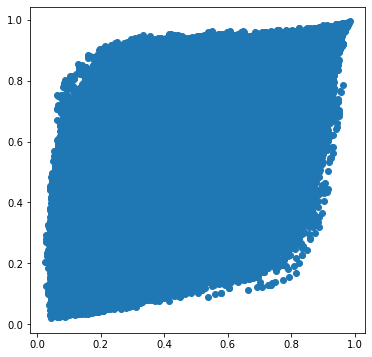

In [29]:
x_test_encoded = autoencoder.predict(x_test, batch_size=8)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], cmap='tab10')

plt.show()

In [30]:
top_10=[]

In [31]:
ooo=0

In [32]:
while ooo<10:
    top_10.append(arr[ooo])
    ooo+=1
    

In [33]:
print(top_10)

[0.57128274, 0.57042587, 0.6140865, 0.6595593, 0.6108479, 0.58195466, 0.62981904, 0.5630053, 0.5550866, 0.59696513]


In [34]:
top_10=np.sort(top_10)

In [35]:
top_10=np.flip(top_10)

In [36]:
print(top_10)

[0.6595593  0.62981904 0.6140865  0.6108479  0.59696513 0.58195466
 0.57128274 0.57042587 0.5630053  0.5550866 ]


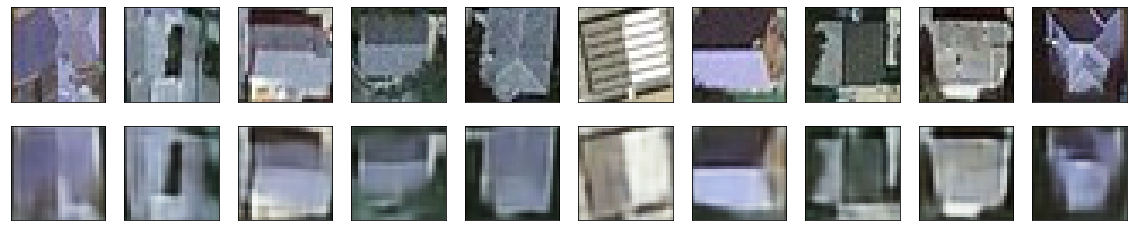

In [37]:

n=10
plt.figure(figsize=(20, 4))
for q4 in range(0, len(arr)):
    for i in range(0, n):
        if np.mean(tf.losses.binary_crossentropy(x_test[q4], decoded_imgs[q4]))==top_10[i]:
            
            
                # display original
                
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(x_test[q4].reshape(28, 28, 3))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                
                # display reconstruction
                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(decoded_imgs[q4].reshape(28, 28, 3))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
    
    
                

        
plt.show()  

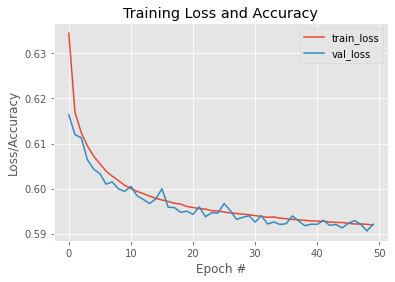

In [45]:
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

In [56]:
import numpy as np
resized_images=np.array(resized_images)


In [57]:
x_train, x_test = train_test_split(resized_images, test_size=0.30)

In [58]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 3))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 3)) 

In [63]:
input_size = 3
hidden_size = 128
code_size = 32

#input_img = Input(shape=(input_size))
input_img = Input(shape=(28, 28, 3))  
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=50)

Epoch 1/50
29931/29931 [==============================] - 84s 3ms/step - loss: 0.5813: 0s - loss: 
Epoch 2/50
29931/29931 [==============================] - 86s 3ms/step - loss: 0.5760
Epoch 3/50
29931/29931 [==============================] - 91s 3ms/step - loss: 0.5758
Epoch 4/50
29931/29931 [==============================] - 91s 3ms/step - loss: 0.5757
Epoch 5/50
29931/29931 [==============================] - 86s 3ms/step - loss: 0.5756: - ETA: 3s -
Epoch 6/50
29931/29931 [==============================] - 87s 3ms/step - loss: 0.5756
Epoch 7/50
29931/29931 [==============================] - 106s 4ms/step - loss: 0.5756
Epoch 8/50
29931/29931 [==============================] - 102s 3ms/step - loss: 0.5756
Epoch 9/50
29931/29931 [==============================] - 99s 3ms/step - loss: 0.5755
Epoch 10/50
29931/29931 [==============================] - 92s 3ms/step - loss: 0.5755
Epoch 11/50
29931/29931 [==============================] - 86s 3ms/step - loss: 0.5755
Epoch 12/50
29931/29931 

In [64]:
decoded_imgs = autoencoder.predict(x_test)


<function matplotlib.pyplot.show(*args, **kw)>

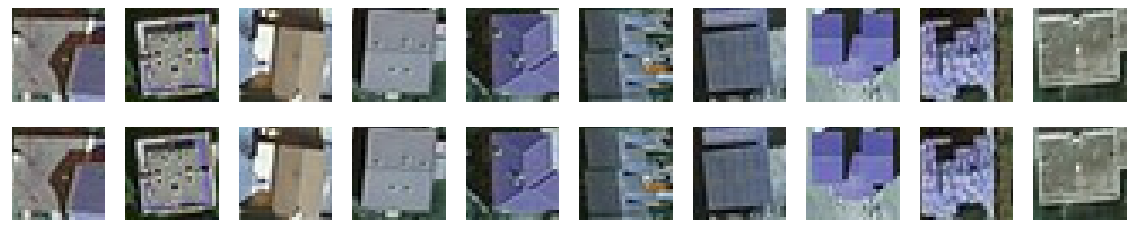

In [65]:

import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show

average cross-entropy = 0.60879356
average cross-entropy = 0.5451168
average cross-entropy = 0.58521545
average cross-entropy = 0.60217464
average cross-entropy = 0.56807446
average cross-entropy = 0.5933283
average cross-entropy = 0.5927272
average cross-entropy = 0.6143186
average cross-entropy = 0.5587657
average cross-entropy = 0.6174077


<function matplotlib.pyplot.show(*args, **kw)>

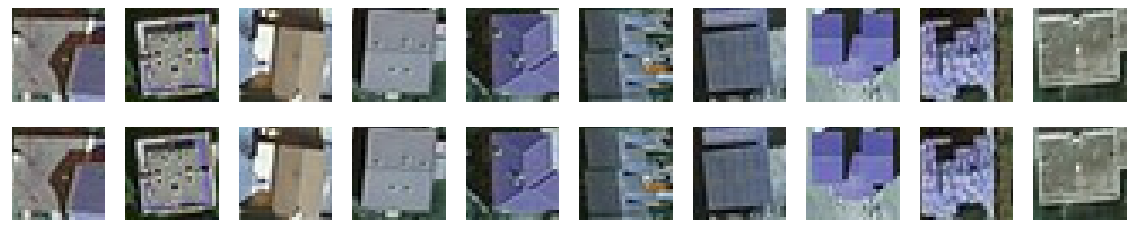

In [66]:
import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    print("average cross-entropy =", np.mean(tf.losses.binary_crossentropy(x_test[i], decoded_imgs[i])))
    
    
    
plt.show

In [67]:
for lll in range(len(x_test)):
    print(np.mean(tf.losses.binary_crossentropy(x_test[lll], decoded_imgs[lll])))
    

0.60879356
0.5451168
0.58521545
0.60217464
0.56807446
0.5933283
0.5927272
0.6143186
0.5587657
0.6174077
0.63075733
0.54597205
0.54028773
0.6184796
0.5500795
0.56943744
0.5226776
0.58668065
0.57853067
0.54198116
0.5774035
0.62726915
0.6153254
0.62539417
0.4945523
0.5583107
0.54558253
0.53554565
0.58063495
0.55540025
0.55996215
0.53837633
0.6119739
0.49674672
0.6285097
0.61245596
0.6038207
0.585105
0.6127883
0.57103634
0.65692514
0.5943576
0.58256805
0.5988734
0.60577166
0.5748977
0.601238
0.60252476
0.5548619
0.3767058
0.47522834
0.5821464
0.5537819
0.55448663
0.5815358
0.57594854
0.5938524
0.62267005
0.6171013
0.61733127
0.58909065
0.6083546
0.5606919
0.5863297
0.53157127
0.5703862
0.6073144
0.60296726
0.6054073
0.5504457
0.55922574
0.63762766
0.62957925
0.5734296
0.60322714
0.60079813
0.502769
0.64060456
0.45478767
0.59663445
0.57947564
0.49188727
0.6202164
0.5609443
0.62724453
0.6119669
0.5077063
0.57258725
0.49928242
0.65066457
0.59718627
0.5674533
0.56471413
0.4548304
0.5662695
0.5

0.62865144
0.48150182
0.633443
0.57595307
0.6237521
0.59602505
0.5337436
0.57637084
0.6124942
0.56410646
0.3767058
0.5739869
0.5908384
0.62231493
0.5625692
0.6117201
0.64407647
0.5840621
0.6310136
0.56244814
0.500554
0.5381567
0.61644536
0.58827347
0.60295683
0.6356067
0.51607394
0.6125115
0.5720165
0.54364926
0.6090754
0.56588477
0.6020176
0.5891573
0.6040549
0.5623513
0.57071894
0.62163675
0.57050604
0.5846089
0.55607575
0.5999357
0.5670379
0.54200083
0.58745337
0.57501024
0.5405794
0.60828626
0.6156708
0.67146397
0.5478472
0.573173
0.578465
0.6174145
0.54109925
0.53424555
0.53638256
0.5670235
0.3151354
0.5762972
0.635305
0.607091
0.6223365
0.5837671
0.5825806
0.6212261
0.55910504
0.583548
0.6357176
0.5757708
0.588262
0.51145405
0.584285
0.5659119
0.53661275
0.5243731
0.28867596
0.59672445
0.48225915
0.5857965
0.57943845
0.44201282
0.5949684
0.602884
0.6323863
0.6328118
0.57641315
0.6067785
0.5775078
0.5890787
0.5811767
0.56502897
0.56981635
0.5986824
0.52019125
0.5632336
0.55396163


0.596563
0.45729184
0.6202393
0.6313556
0.56871444
0.61439025
0.60692245
0.58902764
0.6052501
0.60196745
0.53303343
0.54671276
0.5839917
0.5616591
0.5726374
0.58434725
0.6229629
0.560243
0.54791105
0.58440953
0.6314517
0.588723
0.59185284
0.5682366
0.61206967
0.549523
0.58843714
0.57179725
0.62067497
0.57302374
0.5182885
0.6181632
0.58119035
0.5834333
0.5630625
0.6389832
0.5694264
0.5468394
0.52383065
0.5691571
0.5684163
0.550707
0.56897855
0.5917054
0.5245847
0.59865516
0.5409117
0.5858601
0.5605754
0.57362306
0.5935611
0.5852392
0.6199213
0.6158631
0.5647749
0.5353284
0.62355626
0.5989518
0.54392016
0.48612076
0.58333653
0.6080757
0.6250244
0.60667235
0.6621514
0.6404792
0.42663458
0.5266845
0.58519435
0.56151044
0.5915907
0.52974665
0.643393
0.60774654
0.48746747
0.5992225
0.5845836
0.59024954
0.56807107
0.56110615
0.5456639
0.6557748
0.5762219
0.60061777
0.5592736
0.5435319
0.5759661
0.58918005
0.61913186
0.6286738
0.5385044
0.55079806
0.6056412
0.5766171
0.56893593
0.52193755
0.60

0.5804582
0.55165654
0.5930496
0.6285061
0.5823646
0.57265073
0.59367317
0.54075336
0.48514432
0.5687517
0.5749221
0.5121484
0.53987473
0.51588726
0.55212015
0.45849925
0.6063064
0.6008192
0.5655924
0.5927725
0.49897477
0.62747735
0.5763099
0.45588773
0.5447046
0.5413018
0.57972765
0.5877414
0.60232854
0.5587489
0.5719164
0.54055226
0.5795744
0.61420804
0.56586844
0.588413
0.5791487
0.583243
0.58855337
0.5431429
0.5432137
0.5754351
0.53510517
0.49235225
0.5966548
0.62149423
0.6141421
0.58292955
0.60385686
0.6326327
0.5797272
0.56745803
0.5913864
0.5604859
0.644328
0.5830317
0.5753765
0.5995959
0.5459252
0.60991853
0.5102791
0.5818791
0.45831844
0.6728606
0.59379745
0.57297665
0.60536087
0.5325641
0.58517236
0.5258733
0.60414904
0.6559755
0.5723216
0.5595873
0.63059944
0.6123358
0.5264567
0.5772919
0.59940547
0.6018801
0.5962677
0.5926861
0.5452049
0.58456135
0.5906602
0.63419145
0.5730342
0.5940824
0.57820153
0.6279358
0.6197563
0.5409605
0.54676217
0.59053963
0.6367907
0.63495564
0.59

0.5956223
0.57750094
0.6625007
0.6585479
0.53116524
0.5958001
0.6361463
0.24263246
0.52893674
0.5711487
0.5787364
0.532728
0.6135973
0.6089254
0.6004192
0.38035217
0.6218256
0.567368
0.5430132
0.5973477
0.5455663
0.55472976
0.541941
0.58948755
0.5651726
0.6170677
0.6249426
0.5549681
0.58859044
0.53650075
0.604537
0.5960274
0.63337994
0.562483
0.5745921
0.65167844
0.5735185
0.581949
0.5228187
0.5915947
0.570723
0.60175747
0.5606061
0.593547
0.5774379
0.56571627
0.59468615
0.5771683
0.61507237
0.63647234
0.57423407
0.5884618
0.62988013
0.6587703
0.62455654
0.515951
0.5588905
0.5791939
0.5496385
0.52357244
0.6078302
0.6137323
0.564093
0.57071656
0.56485057
0.60409296
0.35667652
0.62419534
0.57784015
0.5367201
0.5321777
0.5603295
0.57723767
0.5910152
0.57996184
0.5901903
0.5988845
0.5825219
0.5998785
0.6024275
0.61544573
0.5861831
0.61762077
0.55255044
0.58818865
0.5897099
0.55044496
0.5076109
0.56918037
0.5789501
0.60175145
0.60872704
0.6168129
0.6461955
0.59548056
0.5387838
0.5918856
0.5

0.5851679
0.62756115
0.5073731
0.60314685
0.43868178
0.5311752
0.5689203
0.62778044
0.6307065
0.59101707
0.57224166
0.5627405
0.42447633
0.55099875
0.5741496
0.5860086
0.55069
0.5491959
0.59440976
0.59582067
0.55268764
0.6154365
0.58296716
0.64520967
0.46786895
0.5635112
0.5411658
0.56632555
0.6152965
0.59437156
0.5715063
0.56562656
0.535418
0.59681684
0.5633294
0.57590944
0.6237409
0.61555713
0.55049455
0.6010622
0.5471341
0.5054139
0.62027717
0.5713132
0.5227729
0.59552026
0.6088046
0.6022713
0.65817493
0.5694471
0.51285154
0.61187696
0.6098958
0.6153295
0.41287076
0.595738
0.5606672
0.6050576
0.59316695
0.6566747
0.5026658
0.6282164
0.6165908
0.55098623
0.57540745
0.6261428
0.54767406
0.60880816
0.58146405
0.5813822
0.6365998
0.5549405
0.5670197
0.5686491
0.5686099
0.5886793
0.5854812
0.60445017
0.5403076
0.5869905
0.59822965
0.57731354
0.5610092
0.61334467
0.6314122
0.56277514
0.56164527
0.56782496
0.5576627
0.56628275
0.53635836
0.55143046
0.63215125
0.60886174
0.5699781
0.5650082

0.6113319
0.562411
0.46885914
0.6272144
0.62415755
0.5760043
0.5513995
0.6070124
0.59816456
0.6225395
0.655177
0.5631834
0.61322963
0.5474706
0.62536246
0.608644
0.4907081
0.5707837
0.58050525
0.588256
0.5912564
0.5515788
0.51962054
0.64260143
0.5573524
0.5202487
0.61856294
0.5205109
0.57842404
0.58367634
0.5303423
0.5049787
0.53660923
0.53291553
0.57307893
0.5615059
0.565936
0.54636604
0.5788069
0.53652453
0.56847906
0.5619744
0.5787372
0.6037386
0.47921172
0.60731745
0.59864324
0.5500402
0.6074213
0.58981836
0.5481674
0.5357368
0.5830663
0.4908016
0.6221728
0.5608568
0.5800158
0.49518666
0.54145986
0.59870964
0.57780516
0.52307874
0.5563789
0.59069175
0.61638033
0.56758356
0.6689646
0.577255
0.5667476
0.55145526
0.5589956
0.54401857
0.3989672
0.5789763
0.6273017
0.5854299
0.6177766
0.60516566
0.6193164
0.577875
0.6270135
0.62648934
0.59006846
0.573715
0.5900244
0.5710387
0.59869254
0.6305364
0.6364992
0.6211969
0.603447
0.5874331
0.55829316
0.580658
0.55051035
0.5601604
0.5271931
0.6

0.29888245
0.6183702
0.51893306
0.5992429
0.5655637
0.5842958
0.53941685
0.5818732
0.5670935
0.59706455
0.60678834
0.5244963
0.57351065
0.5680428
0.5721955
0.5663753
0.54899883
0.55919236
0.4931234
0.48112518
0.57747275
0.60973454
0.5392744
0.5665403
0.6346616
0.5739984
0.5755312
0.5761432
0.593766
0.5904391
0.5560066
0.5819844
0.63927734
0.5294965
0.59141636
0.578274
0.58005124
0.57265633
0.5727128
0.5947916
0.62521523
0.4391319
0.5786323
0.49941632
0.5850436
0.59080654
0.65367764
0.55713594
0.616352
0.5815801
0.57316077
0.5869947
0.5878386
0.60976326
0.64742327
0.461068
0.528273
0.47579068
0.5243299
0.5721291
0.5926026
0.62283564
0.58006346
0.5707993
0.5888127
0.5697166
0.63091105
0.58743715
0.53691226
0.6250834
0.51666605
0.561405
0.56789756
0.5979763
0.5511073
0.57343906
0.50454277
0.5604606
0.591903
0.61424816
0.65141916
0.6139565
0.5729543
0.55684793
0.547915
0.62023854
0.6372381
0.59625363
0.5743153
0.5518574
0.63834566
0.48037004
0.6120761
0.6189522
0.62148917
0.56875175
0.5581

0.5910075
0.54288876
0.6272559
0.6176209
0.58775234
0.5322566
0.58099693
0.5267244
0.5715536
0.49775314
0.6273035
0.5786095
0.56075716
0.5970669
0.54849464
0.574842
0.5781458
0.55936456
0.58592135
0.6352308
0.5778723
0.5979155
0.5895606
0.6085857
0.5346928
0.5885817
0.60031307
0.58613926
0.6063027
0.5508437
0.47744945
0.59453106
0.58069426
0.6259669
0.5781204
0.6003405
0.57819986
0.57048744
0.53456044
0.6174034
0.63578355
0.55270827
0.56907433
0.5818973
0.6004853
0.61156064
0.5888166
0.5842658
0.5025195
0.5467295
0.58974195
0.6200842
0.5924075
0.6041741
0.63690716
0.5832573
0.5642085
0.6283059
0.48116976
0.6137019
0.63939214
0.524237
0.5750985
0.59778273
0.57068336
0.60482377
0.5962769
0.5639109
0.5698166
0.58673066
0.5993979
0.5331438
0.57597
0.5889046
0.63452
0.62298936
0.5129425
0.54670393
0.5894904
0.5672186
0.43026477
0.6415441
0.5671974
0.607852
0.5266716
0.58842313
0.579935
0.59382963
0.6028442
0.61982805
0.4783218
0.43190256
0.55735624
0.55035675
0.5855243
0.6050403
0.5924431
0

0.6024799
0.563124
0.598569
0.48191303
0.638439
0.45424
0.54103565
0.5862864
0.6274272
0.5734209
0.6273652
0.5811928
0.57377034
0.55428284
0.5506875
0.5483712
0.5878073
0.59384125
0.56060797
0.5836139
0.5473884
0.5667212
0.5773824
0.5531061
0.5984656
0.58828896
0.6054682
0.58725274
0.56656563
0.57539034
0.6146909
0.6191355
0.60701543
0.4638795
0.6132776
0.59317225
0.53021663
0.58416176
0.58409965
0.5667794
0.59579283
0.4961807
0.56196845
0.5924775
0.58033746
0.6400411
0.56517833
0.5945368
0.60007495
0.5407813
0.6399768
0.61893
0.6674377
0.61572665
0.634379
0.5438165
0.59752715
0.55812305
0.59899753
0.5792483
0.59098256
0.4885039
0.4853406
0.58562016
0.53276235
0.577198
0.5740198
0.5857888
0.5905159
0.63797456
0.43919885
0.5671065
0.59465533
0.5820828
0.6090236
0.5625095
0.58885854
0.59416074
0.54358643
0.5679046
0.4546768
0.55932206
0.5451626
0.53568244
0.5925797
0.6321965
0.52436477
0.56008446
0.54658693
0.5545019
0.5140921
0.56691515
0.61001176
0.5215951
0.59928125
0.5271087
0.495680

0.56541723
0.6062988
0.59007585
0.55661124
0.59954536
0.5991335
0.6323769
0.6085582
0.564319
0.64512986
0.6140955
0.57443196
0.52933985
0.5870714
0.5486381
0.4716681
0.5945581
0.5654997
0.62951356
0.574931
0.58389986
0.48490703
0.5515716
0.6169839
0.4490916
0.57465726
0.58522904
0.54740566
0.58850014
0.6156294
0.5264775
0.5805041
0.5775373
0.55369174
0.6121639
0.5610914
0.5082616
0.620213
0.60299444
0.56619406
0.44691744
0.5600295
0.58989304
0.537156
0.5664955
0.5771379
0.51118284
0.5627204
0.6406619
0.60880184
0.52841485
0.5989518
0.5750557
0.5446734
0.35712302
0.630233
0.60033816
0.5527365
0.63225543
0.61871344
0.6076149
0.54546237
0.57859206
0.554182
0.6318336
0.5733617
0.5859037
0.57304543
0.53509027
0.6328197
0.5491368
0.627001
0.5851899
0.583731
0.60847265
0.6386955
0.59650564
0.5787501
0.56726223
0.52429783
0.61432934
0.5540655
0.6106651
0.653656
0.5549463
0.59931225
0.3835081
0.52959234
0.5726402
0.52089
0.6149047
0.5980201
0.5235448
0.5383295
0.6320626
0.57630056
0.5581475
0.5

0.6085241
0.5513371
0.5996528
0.56818664
0.5505895
0.628646
0.5547168
0.6099536
0.53255785
0.60578614
0.4633937
0.59775865
0.58203286
0.4919629
0.6221146
0.5187098
0.5301614
0.5828581
0.6146427
0.59599465
0.5429274
0.6792731
0.5204087
0.52492756
0.5492591
0.5868422
0.5709019
0.6174895
0.55490303
0.5976244
0.60338676
0.5810761
0.5893761
0.55513114
0.6194798
0.55703324
0.4766624
0.4742585
0.60626644
0.5651035
0.614545
0.59777266
0.4708996
0.60284853
0.5087137
0.61003697
0.6143832
0.5846637
0.5897542
0.56510496
0.54047596
0.5979946
0.5995509
0.5696129
0.5900277
0.53894275
0.60883105
0.5364514
0.5905723
0.6026888
0.5805409
0.6153272
0.5682074
0.62283754
0.5713219
0.5892721
0.64301556
0.61541075
0.6058161
0.51279086
0.67176634
0.5679501
0.598949
0.5805567
0.6044593
0.5682211
0.621789
0.61716205
0.5939085
0.5798131
0.5942128
0.5136831
0.62533444
0.6066271
0.617643
0.493544
0.57595545
0.59081197
0.55235386
0.57539475
0.58174443
0.55760896
0.5786143
0.5766252
0.57201046
0.6203658
0.56613314
0.

0.60614926
0.59655756
0.6424504
0.5740224
0.5902745
0.5939501
0.6523497
0.6025889
0.5673717
0.55991167
0.5917064
0.6320022
0.6081073
0.5905337
0.60593396
0.63569075
0.57302797
0.47820082
0.534791
0.5519437
0.5990512
0.60521096
0.56656504
0.62559825
0.6159276
0.5749267
0.5634544
0.6192304
0.6270877
0.65497226
0.58028644
0.5901953
0.6079505
0.5971418
0.6421717
0.5398163
0.57559514
0.5986653
0.61906016
0.55888504
0.5527352
0.58098215
0.37415785
0.58821964
0.5835113
0.5298887
0.60110176
0.592094
0.5798493
0.60683143
0.594954
0.55554193
0.5961699
0.6631823
0.5566346
0.5625831
0.6044275
0.5923123
0.5624404
0.55499244
0.5420255
0.51282215
0.57364273
0.571708
0.6149535
0.61838
0.5715779
0.35935134
0.6151627
0.5568623
0.5205211
0.6295708
0.6310794
0.579188
0.6037952
0.6100149
0.56493044
0.64647746
0.65945137
0.54742604
0.48683736
0.33290443
0.5798624
0.6064916
0.621067
0.6004262
0.6364829
0.518984
0.55790615
0.55027765
0.6083571
0.6138447
0.55555224
0.6467671
0.51048625
0.59384316
0.5234312
0.6

0.5571469
0.6443322
0.56102407
0.5541251
0.5968766
0.49801067
0.5812722
0.63864446
0.55369246
0.567123
0.61794
0.6325591
0.5532194
0.58216786
0.54501104
0.5808273
0.5925788
0.47384566
0.6040864
0.5503517
0.5385978
0.5311531
0.6523497
0.57684493
0.5321986
0.6477621
0.5636303
0.5846796
0.48994666
0.59567416
0.6075567
0.63945717
0.5396322
0.59081167
0.61794925
0.5887469
0.5850601
0.53443646
0.6018377
0.5832429
0.61239403
0.59999603
0.5965052
0.39283532
0.5224273
0.52356625
0.6046398
0.5776978
0.6136419
0.513365
0.6051707
0.5937344
0.45129424
0.566281
0.48673287
0.49873832
0.5075487
0.61381114
0.5862014
0.6142556
0.6536079
0.6184993
0.6153819
0.5841141
0.64556
0.5916013
0.6151066
0.6300064
0.5857339
0.5683888
0.58772486
0.5141884
0.4660976
0.5425647
0.59866446
0.5383881
0.43044996
0.5843428
0.5529186
0.6294134
0.630737
0.5808757
0.513728
0.5982554
0.6180085
0.5571857
0.6108892
0.56497806
0.62893045
0.5544739
0.54251677
0.5753509
0.5624754
0.63132507
0.5544948
0.59183913
0.56599224
0.585765

0.5809492
0.5728581
0.58562016
0.583836
0.62988263
0.58867395
0.5710899
0.5229807
0.5639244
0.5218036
0.5150136
0.56247675
0.58945614
0.5768674
0.546527
0.6275244
0.5909882
0.6138258
0.56039995
0.596068
0.5754242
0.5723908
0.6334359
0.56265265
0.61041343
0.5806041
0.6191277
0.5457037
0.5463628
0.5780718
0.47763416
0.60335076
0.56403786
0.557802
0.64884716
0.52608687
0.57943845
0.5999017
0.42500624
0.5981142
0.52656513
0.5483085
0.5636599
0.6338943
0.57161564
0.55847454
0.47802764
0.51791096
0.6196681
0.62272495
0.57943815
0.56947947
0.56805664
0.5944923
0.527131
0.5842336
0.540009
0.5883192
0.5959782
0.64481604
0.59660083
0.6159221
0.6124853
0.63368344
0.58978367
0.58648956
0.5526789
0.5514185
0.63025635
0.5996744
0.57330126
0.56643903
0.5897761
0.52063704
0.59428436
0.23905067
0.54859054
0.62105703
0.54598546
0.58531004
0.5809567
0.5769321
0.47110492
0.6480434
0.54861957
0.5587243
0.58896804
0.6355878
0.5783627
0.61564374
0.5561506
0.61424017
0.60328823
0.5806531
0.5302238
0.5722803
0

0.5539417
0.6411458
0.57962084
0.64097416
0.5783705
0.59056896
0.59857255
0.5905794
0.6012613
0.60235244
0.5824056
0.6021306
0.5170435
0.5929461
0.6178724
0.5859625
0.5947747
0.30745006
0.65605426
0.566069
0.5810303
0.54591084
0.54893655
0.54808736
0.58873224
0.3975521
0.5916951
0.5697078
0.5612666
0.6506851
0.6025674
0.6110858
0.5399609
0.60109484
0.5563748
0.5860695
0.5960849
0.60385585
0.61744386
0.56343204
0.6722175
0.5022998
0.58903664
0.6135238
0.5996739
0.64000213
0.6000709
0.60553277
0.5638159
0.59942305
0.5123166
0.6200515
0.48837954
0.6329442
0.6301467
0.5884407
0.64245886
0.5589922
0.5994838
0.5068268
0.56429493
0.5746507
0.5939825
0.55807877
0.52880424
0.6116639
0.5324935
0.5512996
0.5261204
0.63490415
0.55109805
0.6260154
0.5443514
0.5169012
0.62110156
0.58624125
0.5278957
0.5850918
0.5274472
0.5783842
0.55094624
0.5437889
0.4957291
0.61606526
0.6592281
0.6533557
0.5806571
0.58844626
0.47866488
0.6123533
0.5959489
0.5183091
0.5834187
0.620505
0.55424315
0.6224561
0.5747596

In [70]:
arr=[]


In [71]:

for lll in range(len(x_test)):
    
    arr.append(np.mean(tf.losses.binary_crossentropy(x_test[lll], decoded_imgs[lll])))

In [72]:
for jjj in range(len(arr)):
    print(arr[jjj])

0.60879356
0.5451168
0.58521545
0.60217464
0.56807446
0.5933283
0.5927272
0.6143186
0.5587657
0.6174077
0.63075733
0.54597205
0.54028773
0.6184796
0.5500795
0.56943744
0.5226776
0.58668065
0.57853067
0.54198116
0.5774035
0.62726915
0.6153254
0.62539417
0.4945523
0.5583107
0.54558253
0.53554565
0.58063495
0.55540025
0.55996215
0.53837633
0.6119739
0.49674672
0.6285097
0.61245596
0.6038207
0.585105
0.6127883
0.57103634
0.65692514
0.5943576
0.58256805
0.5988734
0.60577166
0.5748977
0.601238
0.60252476
0.5548619
0.3767058
0.47522834
0.5821464
0.5537819
0.55448663
0.5815358
0.57594854
0.5938524
0.62267005
0.6171013
0.61733127
0.58909065
0.6083546
0.5606919
0.5863297
0.53157127
0.5703862
0.6073144
0.60296726
0.6054073
0.5504457
0.55922574
0.63762766
0.62957925
0.5734296
0.60322714
0.60079813
0.502769
0.64060456
0.45478767
0.59663445
0.57947564
0.49188727
0.6202164
0.5609443
0.62724453
0.6119669
0.5077063
0.57258725
0.49928242
0.65066457
0.59718627
0.5674533
0.56471413
0.4548304
0.5662695
0.5

0.5198057
0.5425783
0.57192147
0.5566602
0.5887046
0.546879
0.55750126
0.5844507
0.5986046
0.61406195
0.6033659
0.62499213
0.53539467
0.6110222
0.59962684
0.5449137
0.6035704
0.61804926
0.56367654
0.54747105
0.6049894
0.554282
0.4548304
0.6178606
0.5485001
0.5346894
0.58104295
0.5955014
0.58148444
0.59748405
0.6216629
0.5552819
0.60024375
0.58955956
0.598984
0.6071188
0.6177551
0.5792248
0.6051759
0.5705734
0.5367014
0.5034526
0.58823097
0.52386373
0.58835727
0.48984885
0.49245286
0.5845164
0.60411936
0.6416294
0.57981586
0.531034
0.58387923
0.6089194
0.6320294
0.56709325
0.5499891
0.57074785
0.57131976
0.59710926
0.58092403
0.555081
0.5667999
0.5497119
0.5789308
0.5919374
0.54166335
0.5464432
0.51765996
0.56134695
0.58675855
0.58447045
0.60212827
0.6218244
0.5672059
0.58482265
0.5851609
0.49057677
0.57058483
0.54623234
0.5947828
0.5252418
0.5511283
0.65043837
0.5645915
0.5636413
0.58835495
0.5832481
0.5514483
0.5394381
0.6027826
0.58084065
0.5915985
0.6197022
0.5818476
0.5811455
0.573

0.6571696
0.5571229
0.6279159
0.5248704
0.5993157
0.6276468
0.5845627
0.57883453
0.575401
0.58885014
0.5033699
0.5797683
0.5258201
0.6251947
0.5713991
0.53717035
0.62241244
0.5206007
0.62049556
0.5877996
0.5667709
0.59459877
0.4795382
0.6427698
0.6009302
0.64964837
0.6000344
0.5796173
0.57496506
0.52473545
0.5737599
0.5943285
0.6495456
0.5526088
0.59310573
0.5469288
0.59817666
0.604913
0.59885347
0.5856573
0.55259156
0.48978072
0.55569124
0.57133925
0.28916866
0.585108
0.5034327
0.54853183
0.5580593
0.5353841
0.512909
0.65274644
0.5026168
0.602593
0.5800137
0.5321723
0.5572013
0.45424
0.59121376
0.53877157
0.528432
0.50685924
0.5731497
0.54699826
0.6103159
0.599777
0.58189696
0.5751938
0.58086073
0.6339442
0.5897543
0.6017131
0.5495857
0.5934685
0.56302077
0.53996885
0.54323757
0.59294045
0.527821
0.6111554
0.58031136
0.6304091
0.5542907
0.56189936
0.549936
0.5661807
0.5811763
0.5690058
0.5126566
0.55356693
0.5948583
0.5880691
0.52891827
0.5154812
0.5534927
0.58351624
0.5337099
0.52578

0.64304984
0.58318764
0.656703
0.5566154
0.6064431
0.49157757
0.6373809
0.56262416
0.5633155
0.5954845
0.57505417
0.53912246
0.60139203
0.47641382
0.55861187
0.5998592
0.5985296
0.5367946
0.6105005
0.6209605
0.6022512
0.6098014
0.48530748
0.57952785
0.5973719
0.576154
0.6579966
0.5658923
0.62625134
0.54836315
0.5296206
0.59529865
0.59949094
0.5967281
0.5475365
0.5814721
0.56877744
0.6013319
0.56992
0.6012387
0.56054103
0.5919374
0.53970283
0.5184137
0.61234206
0.65073615
0.45721185
0.5792937
0.53310096
0.47051108
0.58270234
0.4957555
0.6240586
0.58622104
0.6156664
0.46686748
0.53017306
0.5622785
0.58480966
0.5113597
0.590474
0.64396167
0.52668935
0.5617754
0.6100194
0.61064476
0.5895715
0.5958321
0.63874966
0.60454834
0.55509084
0.6065545
0.63555205
0.51718974
0.547915
0.64949846
0.50549716
0.5870073
0.61186516
0.6216394
0.50891155
0.5469744
0.45424
0.573288
0.5960348
0.55338055
0.4546768
0.60634154
0.6036396
0.58275056
0.63397545
0.5661119
0.53610593
0.6017763
0.5551505
0.5653786
0.59

0.6345738
0.5959671
0.611068
0.53169715
0.58408517
0.49742156
0.621495
0.59967047
0.57272154
0.5885421
0.62289757
0.6064635
0.62217104
0.615587
0.630113
0.6076528
0.51668525
0.61104155
0.5720484
0.57324404
0.6142013
0.46639603
0.5836207
0.5689679
0.64042103
0.53517294
0.6068115
0.6345241
0.5938771
0.5874676
0.6549242
0.60735023
0.6156795
0.57004887
0.5392731
0.57679456
0.56918687
0.56995493
0.57969725
0.58968705
0.5766599
0.6136371
0.6068082
0.5809411
0.55478567
0.5394099
0.63622975
0.6112706
0.6415697
0.57762307
0.585648
0.5367472
0.6276422
0.6266924
0.5116735
0.42005414
0.5401313
0.58850676
0.50300723
0.5457251
0.59618294
0.58029217
0.6291815
0.59470016
0.5238328
0.5970621
0.6001081
0.6185659
0.6418555
0.61592895
0.57224166
0.31646374
0.62888587
0.5003674
0.6049186
0.5866511
0.6165467
0.53593296
0.5509977
0.5632769
0.63893783
0.50336105
0.5411706
0.52253574
0.6269168
0.5887947
0.57887286
0.579449
0.6218958
0.606425
0.6239821
0.5454389
0.5753045
0.55707985
0.6495928
0.42618117
0.62172

0.65080076
0.5466527
0.60977995
0.566417
0.61138326
0.5611859
0.65233266
0.56150967
0.52447
0.58768034
0.58914304
0.60830903
0.5977566
0.5785125
0.5920446
0.5673262
0.60946894
0.5438252
0.59735864
0.6054491
0.58070356
0.53141904
0.545329
0.53701764
0.6015032
0.42720824
0.52067995
0.55273336
0.5738246
0.60906786
0.61533797
0.594327
0.56450295
0.5378792
0.5854816
0.5398057
0.5860384
0.59871286
0.57015467
0.5559147
0.5758057
0.4267447
0.6212807
0.57259905
0.65867746
0.57167107
0.54305035
0.64113754
0.5499253
0.60249895
0.57608855
0.65606594
0.29888245
0.6183702
0.51893306
0.5992429
0.5655637
0.5842958
0.53941685
0.5818732
0.5670935
0.59706455
0.60678834
0.5244963
0.57351065
0.5680428
0.5721955
0.5663753
0.54899883
0.55919236
0.4931234
0.48112518
0.57747275
0.60973454
0.5392744
0.5665403
0.6346616
0.5739984
0.5755312
0.5761432
0.593766
0.5904391
0.5560066
0.5819844
0.63927734
0.5294965
0.59141636
0.578274
0.58005124
0.57265633
0.5727128
0.5947916
0.62521523
0.4391319
0.5786323
0.49941632
0

0.4783218
0.43190256
0.55735624
0.55035675
0.5855243
0.6050403
0.5924431
0.5646639
0.54464823
0.6022923
0.5981953
0.56045663
0.6205473
0.58774483
0.5774577
0.5202327
0.5802833
0.63487005
0.5769041
0.6171784
0.60517824
0.55554146
0.5640675
0.55725664
0.5793552
0.59504175
0.62561196
0.59223515
0.60478693
0.56799436
0.57873994
0.6063087
0.6114122
0.5429121
0.5792327
0.5949555
0.5841745
0.6105303
0.60355765
0.6276336
0.5930642
0.40981767
0.4591741
0.5684445
0.56747097
0.6609722
0.56548584
0.5482941
0.54367983
0.6110423
0.585191
0.5941882
0.5267884
0.5507754
0.57361776
0.5549742
0.60625136
0.60704136
0.6285629
0.5837993
0.55571973
0.5317462
0.5963228
0.42360377
0.61834615
0.45716462
0.5975316
0.57118607
0.6218849
0.61179787
0.5359128
0.55423313
0.55860347
0.6528621
0.58424383
0.5853716
0.57011265
0.6027036
0.6277894
0.52398986
0.6311748
0.6038103
0.63160074
0.55924207
0.6397811
0.5022745
0.5120331
0.5504496
0.5155304
0.53916633
0.6427073
0.582355
0.6093719
0.5903554
0.5870512
0.5990366
0.59

0.5580707
0.5360327
0.61063707
0.57225776
0.66068596
0.5329387
0.60343784
0.6022302
0.55932844
0.56118345
0.58825296
0.49613473
0.5700594
0.5066202
0.5543262
0.58546555
0.5251581
0.62198466
0.585628
0.592458
0.5327028
0.5612896
0.581764
0.5649307
0.5900444
0.5859069
0.60622364
0.5725216
0.65744394
0.5635417
0.6278836
0.65568155
0.53750277
0.64997363
0.5821694
0.57328856
0.6143974
0.58232236
0.5564048
0.5662671
0.57824326
0.6252827
0.5580521
0.5713256
0.5458873
0.5678472
0.6108347
0.55666703
0.58728284
0.5684866
0.51685625
0.6033192
0.57019764
0.5455264
0.586741
0.5330899
0.6153345
0.59045035
0.6145397
0.564265
0.6104887
0.5855204
0.6274145
0.6061814
0.53773296
0.49077177
0.6247668
0.6329442
0.6102419
0.5840864
0.5751725
0.5956418
0.6323399
0.6039941
0.5679803
0.54472786
0.6065173
0.53900003
0.6127883
0.60636735
0.6009346
0.57117486
0.50800115
0.55657256
0.58237475
0.62899774
0.59678906
0.63195986
0.5770126
0.58251035
0.49331376
0.5383295
0.5663362
0.58166605
0.58472246
0.63037777
0.536

0.4277486
0.5057874
0.6544881
0.60709804
0.5415927
0.55656093
0.51140577
0.5532208
0.60486263
0.34968877
0.5766795
0.60181636
0.5539133
0.57552636
0.48290142
0.6120558
0.58059126
0.62006235
0.6053901
0.57754636
0.5191207
0.588403
0.6085241
0.5513371
0.5996528
0.56818664
0.5505895
0.628646
0.5547168
0.6099536
0.53255785
0.60578614
0.4633937
0.59775865
0.58203286
0.4919629
0.6221146
0.5187098
0.5301614
0.5828581
0.6146427
0.59599465
0.5429274
0.6792731
0.5204087
0.52492756
0.5492591
0.5868422
0.5709019
0.6174895
0.55490303
0.5976244
0.60338676
0.5810761
0.5893761
0.55513114
0.6194798
0.55703324
0.4766624
0.4742585
0.60626644
0.5651035
0.614545
0.59777266
0.4708996
0.60284853
0.5087137
0.61003697
0.6143832
0.5846637
0.5897542
0.56510496
0.54047596
0.5979946
0.5995509
0.5696129
0.5900277
0.53894275
0.60883105
0.5364514
0.5905723
0.6026888
0.5805409
0.6153272
0.5682074
0.62283754
0.5713219
0.5892721
0.64301556
0.61541075
0.6058161
0.51279086
0.67176634
0.5679501
0.598949
0.5805567
0.6044593

0.55555224
0.6467671
0.51048625
0.59384316
0.5234312
0.6190293
0.5751267
0.62267375
0.6083579
0.57178116
0.56725025
0.6173884
0.55310714
0.6264221
0.5714736
0.5655811
0.5796362
0.6030763
0.5977697
0.60520357
0.57250065
0.56538075
0.5694502
0.57316595
0.5441033
0.55106235
0.5711034
0.58754706
0.47118786
0.54972816
0.5967164
0.55689263
0.5270799
0.6001251
0.5366109
0.5812539
0.47388917
0.58908594
0.6013842
0.5412485
0.6219039
0.58553797
0.5737729
0.49818677
0.57118684
0.56368893
0.61526257
0.57354563
0.49703416
0.60048354
0.3693259
0.5601685
0.6208199
0.5530381
0.5268369
0.5896415
0.563491
0.5861072
0.59011006
0.59974146
0.6507846
0.5772067
0.5854124
0.55353427
0.45555303
0.5498927
0.5381001
0.5946805
0.57747114
0.6162611
0.57244515
0.5590381
0.5812526
0.5628238
0.60908747
0.59801465
0.6121828
0.66239244
0.598082
0.47297007
0.58397496
0.5918857
0.5405215
0.5894629
0.6097147
0.57540387
0.5807699
0.5483862
0.6092868
0.53715116
0.5078418
0.59906507
0.5860598
0.6292578
0.536246
0.64358085
0.

0.5681491
0.53899235
0.42385748
0.59415394
0.5733571
0.60417193
0.60349435
0.6213505
0.56500363
0.59918004
0.5826311
0.5575015
0.56711626
0.56734484
0.60982966
0.5452767
0.62862456
0.57416785
0.5670834
0.6212237
0.5551691
0.5412519
0.59833026
0.51210296
0.57990795
0.607795
0.6547503
0.6079171
0.576362
0.5599779
0.33890703
0.56801957
0.5573411
0.58850473
0.57642925
0.6009137
0.56222785
0.5737672
0.59731823
0.58016527
0.60494906
0.58977205
0.6291804
0.60354507
0.61685354
0.5223441
0.5831063
0.56295455
0.58680755
0.5976894
0.5587159
0.5708145
0.6264287
0.57214
0.59874195
0.6136275
0.63749164
0.6218027
0.6392894
0.6079544
0.5514681
0.5911386
0.64094454
0.6225176
0.5582027
0.5810837
0.61328554
0.58916575
0.55084723
0.5411305
0.5408081
0.55783343
0.5511495
0.5125325
0.58755994
0.5948642
0.641683
0.54861367
0.5843534
0.6573525
0.6002369
0.58869445
0.604791
0.50238377
0.6128079
0.5493859
0.5723216
0.6235873
0.56743014
0.6024457
0.64913565
0.58831674
0.5940365
0.6365984
0.5994917
0.5080944
0.57

0.547026
0.23677188
0.6126488
0.59075654
0.51584536
0.57612485
0.5801649
0.519587
0.50018424
0.61615944
0.58818644
0.6242776
0.56222785
0.5891141
0.57877713
0.6300202
0.5550855
0.5954608
0.50972843
0.63843024
0.55770093
0.6195428
0.57392097
0.60198563
0.55803955
0.5841141
0.55630267
0.5790397
0.59825236
0.624672
0.6031238
0.59607905
0.6098852
0.5373857
0.5951102
0.5720817
0.57950705
0.6002436
0.53631103
0.3244593
0.51408076
0.5577991
0.6090867
0.61238897
0.48928997
0.55693287
0.56003743
0.60152596
0.59860325
0.59296167
0.5500509
0.595851
0.5834455
0.5836208
0.5802328
0.54784894
0.5098797
0.5249553
0.6393669
0.56915003
0.52960044
0.59859324
0.5894246
0.6123237
0.5933172
0.58141667
0.58933514
0.5705922
0.6067126
0.60229445
0.6099641
0.66050076
0.60560733
0.56726354
0.5969244
0.660703
0.49615735
0.5655152
0.58711773
0.6045979
0.63721675
0.5842648
0.5589868
0.6652188
0.60206884
0.5878095
0.5898831
0.5733428
0.62520325
0.5990966
0.6234959
0.59724087
0.60360104
0.5900137
0.5193802
0.5491918


In [73]:
print(arr)

[0.60879356, 0.5451168, 0.58521545, 0.60217464, 0.56807446, 0.5933283, 0.5927272, 0.6143186, 0.5587657, 0.6174077, 0.63075733, 0.54597205, 0.54028773, 0.6184796, 0.5500795, 0.56943744, 0.5226776, 0.58668065, 0.57853067, 0.54198116, 0.5774035, 0.62726915, 0.6153254, 0.62539417, 0.4945523, 0.5583107, 0.54558253, 0.53554565, 0.58063495, 0.55540025, 0.55996215, 0.53837633, 0.6119739, 0.49674672, 0.6285097, 0.61245596, 0.6038207, 0.585105, 0.6127883, 0.57103634, 0.65692514, 0.5943576, 0.58256805, 0.5988734, 0.60577166, 0.5748977, 0.601238, 0.60252476, 0.5548619, 0.3767058, 0.47522834, 0.5821464, 0.5537819, 0.55448663, 0.5815358, 0.57594854, 0.5938524, 0.62267005, 0.6171013, 0.61733127, 0.58909065, 0.6083546, 0.5606919, 0.5863297, 0.53157127, 0.5703862, 0.6073144, 0.60296726, 0.6054073, 0.5504457, 0.55922574, 0.63762766, 0.62957925, 0.5734296, 0.60322714, 0.60079813, 0.502769, 0.64060456, 0.45478767, 0.59663445, 0.57947564, 0.49188727, 0.6202164, 0.5609443, 0.62724453, 0.6119669, 0.5077063, 

In [74]:
print(np.std(arr))

0.047379743


In [75]:
print(np.mean(arr))

0.5752499


In [76]:
asc_sort=np.sort(arr)

In [77]:
sort_desc=np.flip(asc_sort)

In [78]:
print(sort_desc)

[0.6872633  0.6869192  0.6854905  ... 0.23677188 0.2288767  0.22105362]


In [80]:
result=[]

In [81]:
result = np.where((arr > np.mean(arr) +  3*np.std(arr)))

In [82]:
print(result)

(array([], dtype=int64),)


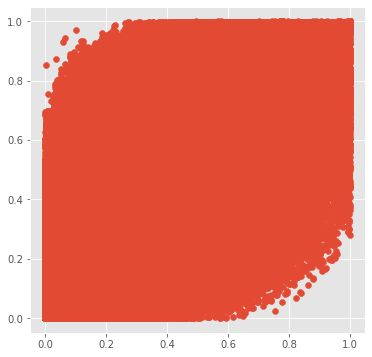

In [83]:
x_test_encoded = autoencoder.predict(x_test, batch_size=8)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], cmap='tab10')

plt.show()

In [84]:
top_10=[]

In [85]:
ooo=0

In [86]:
while ooo<10:
    top_10.append(arr[ooo])
    ooo+=1
    

In [87]:
print(top_10)

[0.60879356, 0.5451168, 0.58521545, 0.60217464, 0.56807446, 0.5933283, 0.5927272, 0.6143186, 0.5587657, 0.6174077]


In [88]:
top_10=np.sort(top_10)

In [89]:
top_10=np.flip(top_10)

In [90]:
print(top_10)

[0.6174077  0.6143186  0.60879356 0.60217464 0.5933283  0.5927272
 0.58521545 0.56807446 0.5587657  0.5451168 ]


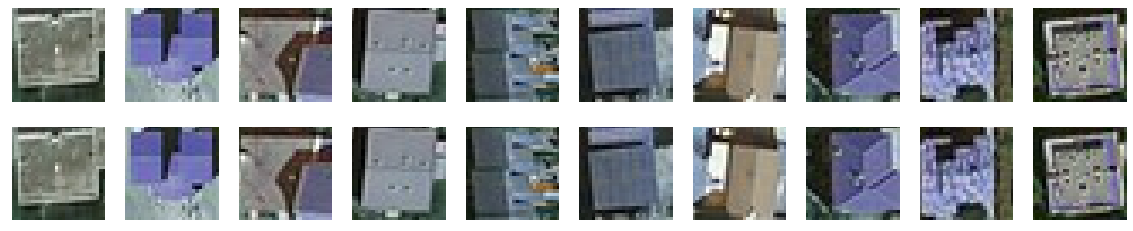

In [91]:

n=10
plt.figure(figsize=(20, 4))
for q4 in range(0, len(arr)):
    for i in range(0, n):
        if np.mean(tf.losses.binary_crossentropy(x_test[q4], decoded_imgs[q4]))==top_10[i]:
            
            
                # display original
                
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(x_test[q4].reshape(28, 28, 3))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                
                # display reconstruction
                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(decoded_imgs[q4].reshape(28, 28, 3))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
    
    
                

        
plt.show()  

In [93]:
H3 = autoencoder.fit(x_train, x_train, epochs=50)

Epoch 1/50
29931/29931 [==============================] - 108s 4ms/step - loss: 0.5755
Epoch 2/50
29931/29931 [==============================] - 89s 3ms/step - loss: 0.5755
Epoch 3/50
29931/29931 [==============================] - 86s 3ms/step - loss: 0.5755
Epoch 4/50
29931/29931 [==============================] - 88s 3ms/step - loss: 0.5755: 0s - loss: 0.
Epoch 5/50
29931/29931 [==============================] - 91s 3ms/step - loss: 0.5755
Epoch 6/50
29931/29931 [==============================] - 85s 3ms/step - loss: 0.5755
Epoch 7/50
29931/29931 [==============================] - 88s 3ms/step - loss: 0.5755
Epoch 8/50
29931/29931 [==============================] - 87s 3ms/step - loss: 0.5755
Epoch 9/50
29931/29931 [==============================] - 88s 3ms/step - loss: 0.5755
Epoch 10/50
29931/29931 [==============================] - 88s 3ms/step - loss: 0.5755
Epoch 11/50
29931/29931 [==============================] - 88s 3ms/step - loss: 0.5755
Epoch 12/50
29931/29931 [===========

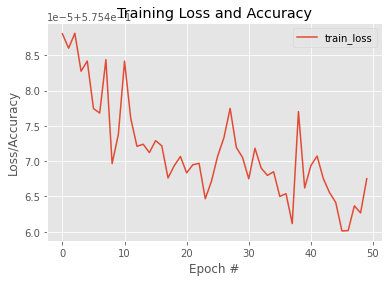

In [97]:
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H3.history["loss"], label="train_loss")
#plt.plot(N, H3.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

In [28]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 3))  





x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)







decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [29]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 28, 28, 64)        1792      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 7, 7, 32)          18464     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 32)          0   

In [30]:
import numpy as np
resized_images=np.array(resized_images)


In [31]:
x_train, x_test = train_test_split(resized_images, test_size=0.30)

In [32]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 3))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 3)) 

In [33]:

H6=autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='\\tmp\\autoencoder')])

Train on 29931 samples, validate on 12828 samples
Epoch 1/50
29931/29931 [==============================] - 319s 11ms/step - loss: 0.6332 - val_loss: 0.6158
Epoch 2/50
29931/29931 [==============================] - 319s 11ms/step - loss: 0.6163 - val_loss: 0.6109
Epoch 3/50
29931/29931 [==============================] - 319s 11ms/step - loss: 0.6108 - val_loss: 0.6151
Epoch 4/50
29931/29931 [==============================] - 319s 11ms/step - loss: 0.6078 - val_loss: 0.6093
Epoch 5/50
29931/29931 [==============================] - 319s 11ms/step - loss: 0.6055 - val_loss: 0.6090
Epoch 6/50
29931/29931 [==============================] - 319s 11ms/step - loss: 0.6038 - val_loss: 0.6030
Epoch 7/50
29931/29931 [==============================] - 319s 11ms/step - loss: 0.6023 - val_loss: 0.6080
Epoch 8/50
29931/29931 [==============================] - 320s 11ms/step - loss: 0.6012 - val_loss: 0.5991
Epoch 9/50
29931/29931 [==============================] - 320s 11ms/step - loss: 0.6002 - val_

In [34]:
decoded_imgs = autoencoder.predict(x_test)


average cross-entropy = 0.63270974
average cross-entropy = 0.537898
average cross-entropy = 0.5940549
average cross-entropy = 0.56563807
average cross-entropy = 0.6052168
average cross-entropy = 0.60022324
average cross-entropy = 0.61312443
average cross-entropy = 0.5756549
average cross-entropy = 0.63466585
average cross-entropy = 0.56093925


<function matplotlib.pyplot.show(*args, **kw)>

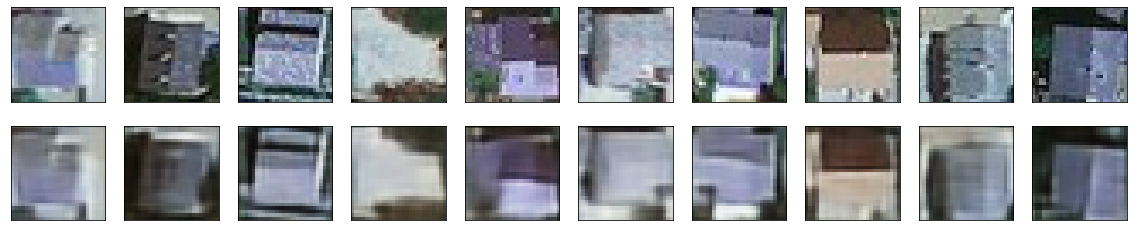

In [35]:

import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    print("average cross-entropy =", np.mean(tf.losses.binary_crossentropy(x_test[i], decoded_imgs[i])))
    
    
    
plt.show

In [36]:
for lll in range(len(x_test)):
    print(np.mean(tf.losses.binary_crossentropy(x_test[lll], decoded_imgs[lll])))
    
    

0.63270974
0.537898
0.5940549
0.56563807
0.6052168
0.60022324
0.61312443
0.5756549
0.63466585
0.56093925
0.5935292
0.5750775
0.57739514
0.6427824
0.61248964
0.5758586
0.57034665
0.66333574
0.51572657
0.61490047
0.618252
0.611929
0.61056536
0.5028602
0.6395429
0.49395993
0.5858711
0.49271464
0.579111
0.5825897
0.6278343
0.5965441
0.6297509
0.5920915
0.5665492
0.6304169
0.565097
0.64765954
0.57715875
0.60802436
0.5877559
0.57148314
0.65056884
0.660091
0.5904875
0.55799484
0.59006965
0.60027754
0.5998862
0.62613845
0.5244748
0.57828414
0.583574
0.5956528
0.6023099
0.6468979
0.49732438
0.55348045
0.607527
0.577339
0.5569534
0.61924994
0.6174669
0.5957477
0.5377567
0.59920377
0.60443044
0.6126289
0.53717506
0.640841
0.5737211
0.6162419
0.61839557
0.5918511
0.5720725
0.5987938
0.5998677
0.63313496
0.6078364
0.66562593
0.5435371
0.65063536
0.5991252
0.5233521
0.59297305
0.6325781
0.589908
0.6325595
0.5928615
0.63577497
0.5986688
0.6344418
0.59977114
0.5593046
0.592127
0.57289684
0.595927
0.53

0.62223303
0.57523274
0.44455314
0.5994957
0.61712664
0.5563945
0.61694473
0.6182821
0.5900402
0.5953481
0.6434911
0.61138374
0.6345414
0.5884211
0.65015405
0.6136446
0.5168708
0.5260633
0.5816419
0.5352483
0.5831256
0.579884
0.6203985
0.60124415
0.6167094
0.5887014
0.638296
0.39605877
0.5676397
0.60504
0.6405442
0.5417481
0.41687268
0.6079044
0.507453
0.599428
0.5643672
0.5324957
0.55708766
0.63913256
0.5068553
0.60658413
0.62817365
0.5869209
0.64765453
0.6146298
0.5706856
0.56616414
0.5854062
0.64633274
0.58347607
0.6188888
0.54544824
0.6075462
0.5380512
0.62084347
0.57818145
0.5836562
0.502385
0.6226564
0.58570945
0.60239875
0.6469128
0.55922717
0.5943328
0.6031238
0.5876422
0.6026212
0.5622086
0.60879976
0.58849335
0.56686085
0.5345226
0.6442488
0.49900335
0.6028549
0.65175736
0.6367557
0.6528597
0.60651606
0.618215
0.506125
0.6489768
0.5762615
0.5843208
0.598702
0.6165722
0.5884142
0.5660038
0.6340396
0.5492352
0.5205927
0.5765112
0.5773306
0.56681514
0.593687
0.5527678
0.6264579


0.5596077
0.56561327
0.60510015
0.59548855
0.5970692
0.62285745
0.5669383
0.6080574
0.54353744
0.63862234
0.61573607
0.5920656
0.5948474
0.59760284
0.63953143
0.53738475
0.5434217
0.5756121
0.6646716
0.5740549
0.6062359
0.5969957
0.645273
0.5217257
0.565218
0.61188674
0.5796095
0.6052876
0.58499324
0.5646678
0.65024024
0.5966555
0.5429737
0.60994136
0.569298
0.5514497
0.5994583
0.5867458
0.59064883
0.6278102
0.614088
0.66514045
0.6168866
0.6178897
0.6360496
0.5620532
0.625756
0.63705903
0.59760505
0.5871148
0.6108708
0.59823644
0.48204875
0.5490738
0.6046518
0.60608435
0.5792854
0.5812198
0.6179695
0.59822106
0.57397085
0.62813824
0.6519757
0.5842833
0.5355364
0.6334699
0.50048244
0.56426835
0.5764753
0.5677857
0.6026093
0.6220279
0.5794264
0.5890306
0.65758413
0.59153646
0.56507486
0.65508443
0.6070476
0.60726947
0.5447964
0.59197074
0.5565958
0.62692255
0.54200095
0.5613862
0.5852916
0.6170845
0.6134839
0.60370636
0.6183721
0.62999415
0.61677927
0.6191825
0.5996584
0.5842216
0.583308

0.6510078
0.65485257
0.5995891
0.57203275
0.57594097
0.5734152
0.40034756
0.57242465
0.6041892
0.5718753
0.613571
0.60722685
0.6397424
0.571991
0.564878
0.6168437
0.6103165
0.551094
0.5993083
0.6254752
0.54063714
0.6077782
0.61251765
0.65639573
0.6346768
0.5961716
0.59414464
0.595839
0.61512965
0.5865918
0.62816584
0.6395079
0.5550359
0.5886502
0.5688754
0.57661265
0.620515
0.5497595
0.66814345
0.6186824
0.6261582
0.60941637
0.5687989
0.6238263
0.5602229
0.6265928
0.5989727
0.5923524
0.618425
0.5660889
0.6281627
0.5739721
0.5854458
0.5975814
0.3421523
0.61971074
0.51158845
0.61195475
0.60944396
0.6539729
0.6070275
0.63633126
0.6350942
0.5859939
0.5887994
0.63802445
0.61820275
0.5462749
0.58680105
0.58880407
0.32914072
0.53139526
0.6065144
0.6067204
0.6112065
0.49831656
0.6396072
0.6134567
0.5416573
0.5736356
0.61520576
0.6261732
0.6192614
0.63073295
0.64966583
0.5937946
0.6187642
0.6210891
0.6127553
0.59046894
0.61138886
0.59915864
0.6177831
0.6420952
0.63316584
0.56880337
0.64727485
0

0.6427838
0.61775136
0.6339226
0.64271706
0.59518725
0.5743377
0.5391077
0.5936368
0.5133838
0.5903832
0.5942661
0.59077775
0.5670037
0.5753502
0.625836
0.6303724
0.5954201
0.60080814
0.5500673
0.5868279
0.6105796
0.61925775
0.60192984
0.6236806
0.605064
0.52094954
0.56810105
0.5757057
0.5924366
0.596135
0.5252093
0.5759722
0.63985777
0.6801921
0.61477154
0.6182406
0.61550546
0.5495387
0.6390552
0.6193881
0.5408482
0.58225596
0.62251914
0.62988514
0.6035491
0.6069972
0.644107
0.6463368
0.53822696
0.6360435
0.5599358
0.5568993
0.60518855
0.60185224
0.45583218
0.60946095
0.59875023
0.6097711
0.6123991
0.6486382
0.6218939
0.579118
0.6151515
0.64454365
0.52818906
0.609371
0.58138895
0.51236963
0.5192021
0.6221321
0.59359217
0.6569732
0.58803886
0.60355914
0.6221093
0.5453428
0.5671093
0.59450614
0.6034128
0.52612126
0.5762983
0.5537746
0.6155708
0.59907985
0.63434374
0.5550374
0.5945248
0.5935689
0.5374789
0.6272026
0.5532456
0.63343257
0.64853776
0.6204506
0.6082364
0.56657296
0.6164227
0

0.5968862
0.5949976
0.35416028
0.5687989
0.62725514
0.5861102
0.55890167
0.6020336
0.60934937
0.6200749
0.59927285
0.60453486
0.590738
0.6354996
0.6410663
0.57373995
0.630886
0.6225867
0.6438478
0.6526901
0.5920856
0.5747676
0.5028163
0.6637634
0.6150784
0.6058321
0.62495345
0.64680207
0.5272036
0.5753424
0.5770564
0.6345874
0.6016012
0.61964613
0.602728
0.5939997
0.6265542
0.6251211
0.572634
0.57891506
0.5798952
0.6155271
0.5617755
0.6444473
0.61423916
0.59340805
0.64990085
0.5760364
0.6435447
0.6066642
0.59626395
0.5744677
0.44514745
0.59217346
0.5935262
0.5771135
0.64006555
0.58200264
0.5842055
0.61281127
0.5636098
0.6380255
0.56504387
0.60198355
0.60828394
0.62866795
0.601353
0.55076504
0.64123183
0.5127997
0.35864577
0.5973153
0.5639049
0.5760641
0.5685372
0.62579906
0.5701363
0.58324414
0.5700559
0.6398657
0.5828985
0.60599476
0.58386683
0.6132368
0.5601035
0.6053256
0.59889585
0.5731
0.5431312
0.6042285
0.5798383
0.5799548
0.63308036
0.5708415
0.5981392
0.60721403
0.58146065
0.5

0.64463955
0.62648726
0.6253252
0.59823984
0.5830149
0.63008213
0.575019
0.60167354
0.5963601
0.6153403
0.5927669
0.5717969
0.5779411
0.5482171
0.58668846
0.6157648
0.6297672
0.60259396
0.57086843
0.6363689
0.6076317
0.6061329
0.62519616
0.650698
0.6184084
0.6011786
0.5430737
0.58056486
0.6196295
0.59158754
0.5900316
0.5273751
0.5918186
0.4922159
0.5558046
0.590439
0.6355102
0.6091305
0.5866692
0.66368645
0.60468465
0.6046412
0.60855263
0.6116037
0.59653354
0.59380156
0.61037195
0.61806154
0.6307485
0.6529498
0.63689774
0.6142254
0.5669492
0.61292106
0.6394046
0.55651295
0.5594585
0.49696544
0.48196563
0.6655834
0.5814814
0.5866078
0.603638
0.6576751
0.5645528
0.5943306
0.6070411
0.6312446
0.601146
0.47921705
0.6452897
0.5884586
0.5643422
0.5457428
0.6202619
0.6010047
0.59926665
0.63634664
0.65589964
0.6151603
0.5534341
0.6641947
0.5504841
0.6181031
0.5526463
0.6436868
0.6269757
0.57836425
0.584638
0.64479035
0.5802256
0.57487667
0.62496215
0.57511955
0.5641744
0.58002424
0.6398936
0.5

0.609121
0.64215344
0.60637844
0.6266559
0.5790444
0.61013776
0.5939536
0.5722425
0.46996042
0.56025344
0.5875915
0.57947534
0.6349472
0.6280385
0.6070772
0.5934934
0.5656075
0.5741663
0.585499
0.58291197
0.58436906
0.6039098
0.60674953
0.5873787
0.6272945
0.6205348
0.6225369
0.5694626
0.6105716
0.6128819
0.60687995
0.55847013
0.6004803
0.54599136
0.60286814
0.5616145
0.51672506
0.58338445
0.564619
0.58859205
0.61955756
0.593509
0.6022776
0.5438769
0.5639941
0.5212586
0.6564377
0.63949865
0.5846131
0.6201373
0.63595396
0.5758728
0.62014383
0.63922495
0.5352819
0.5823896
0.5658082
0.6471856
0.5413959
0.67001086
0.59274524
0.61616194
0.5907587
0.59711146
0.61815464
0.5981671
0.58718103
0.5745496
0.6170662
0.61356753
0.6022402
0.62389153
0.62263626
0.61232704
0.62264633
0.5995965
0.5993279
0.5486992
0.51335776
0.6322561
0.6276438
0.64882845
0.5401391
0.6357657
0.6337138
0.6229668
0.5666357
0.58869225
0.5695143
0.55274266
0.5895401
0.5207812
0.59695095
0.59545016
0.588239
0.56452996
0.6027

0.5902622
0.61797976
0.59829605
0.5548077
0.5633615
0.620491
0.6141644
0.58152056
0.56039
0.6108556
0.4523749
0.632223
0.58400166
0.57307047
0.55438036
0.57780415
0.5815958
0.5809847
0.5428016
0.5017964
0.54463756
0.5096677
0.5986897
0.57391214
0.6099306
0.65873724
0.53487325
0.6132347
0.60304433
0.33843914
0.52002996
0.6193266
0.6151647
0.60975194
0.6214245
0.5905775
0.59983444
0.61303836
0.60581595
0.6103463
0.5734894
0.60125715
0.59977686
0.6164585
0.40629157
0.6345582
0.563467
0.56862736
0.6411601
0.4901285
0.6165458
0.5868143
0.3784748
0.58936656
0.6035347
0.5996312
0.5845115
0.5989204
0.57162315
0.45059177
0.53112924
0.6203659
0.5605969
0.5838444
0.6115795
0.60024405
0.5925311
0.5825434
0.6011723
0.58457404
0.64038575
0.5789621
0.6387861
0.60841227
0.5628093
0.5599888
0.5651911
0.59196573
0.55743587
0.6340928
0.600808
0.5770089
0.59685904
0.52366275
0.5935122
0.5983132
0.5125608
0.61125386
0.616229
0.5983402
0.6267545
0.5880752
0.59442526
0.60485184
0.58441514
0.6798516
0.5926407

0.6394839
0.5812423
0.29162854
0.65991753
0.54508114
0.6311967
0.57820773
0.585952
0.57702917
0.5299674
0.56419337
0.5595557
0.60720474
0.6419316
0.5856253
0.622573
0.60439444
0.66302645
0.6358963
0.6269694
0.5172781
0.58502126
0.63389647
0.6276002
0.57272995
0.5861967
0.6057814
0.5569311
0.58744156
0.6177607
0.5800082
0.61311394
0.5788005
0.58313954
0.54684377
0.62435883
0.608881
0.61520576
0.5318014
0.62021834
0.642241
0.60190535
0.60706687
0.6220608
0.594387
0.5572658
0.56349266
0.63329804
0.59926313
0.5986202
0.56138754
0.553733
0.5735272
0.6208898
0.4704721
0.5948946
0.63755214
0.5800874
0.53115946
0.6101605
0.6088205
0.54367685
0.628607
0.56161237
0.6199078
0.6275662
0.54758775
0.6261689
0.570762
0.61320716
0.6100093
0.6471769
0.63373923
0.6119999
0.5649287
0.5612153
0.56429416
0.6402965
0.55609304
0.64021844
0.60514224
0.5608309
0.6127238
0.6028478
0.5801388
0.580768
0.5657523
0.6374085
0.60827607
0.6079742
0.6101394
0.63449836
0.4588482
0.5831344
0.5632675
0.6113421
0.6025869
0

0.5708878
0.63499904
0.43055102
0.6048077
0.5487026
0.5811812
0.5399753
0.6050272
0.599311
0.6051153
0.61443603
0.5716789
0.5554325
0.6136906
0.5755933
0.56916356
0.5800861
0.61077774
0.51000607
0.6102511
0.58944595
0.6072354
0.60642236
0.5900633
0.6137061
0.55267316
0.65119064
0.57743794
0.59320086
0.6384833
0.61975527
0.5455029
0.5709531
0.5651197
0.600492
0.58057505
0.6619585
0.62189794
0.59339553
0.61634517
0.6008801
0.63694906
0.6125144
0.56452996
0.6503548
0.62518483
0.58959365
0.64779735
0.6423676
0.61569357
0.51421094
0.62877935
0.5676041
0.5635968
0.3384603
0.58140707
0.5635007
0.6625936
0.58982754
0.6313196
0.6061711
0.59486294
0.5969084
0.6076464
0.6001418
0.58783853
0.6028029
0.56893843
0.61633176
0.6758639
0.58518803
0.6078748
0.5664533
0.66904825
0.5769869
0.5477301
0.58162034
0.68405384
0.62639105
0.58521557
0.5734264
0.62331825
0.6086402
0.65855634
0.58176625
0.54727566
0.5834038
0.6319179
0.61398447
0.6194021
0.5930058
0.5781703
0.6449821
0.6116732
0.64770657
0.5313373

0.60387987
0.622787
0.63446695
0.61605
0.59769136
0.56004983
0.5291624
0.6168229
0.59912467
0.6099386
0.60091174
0.6357487
0.6044577
0.5899114
0.5317734
0.55492985
0.6323946
0.62767667
0.564648
0.58062494
0.6341701
0.4776767
0.58485836
0.6014822
0.623193
0.5980701
0.5567908
0.63894314
0.6275453
0.5400615
0.57875663
0.4137951
0.6469632
0.56961703
0.5025482
0.6039278
0.59695697
0.57616466
0.5003952
0.5953234
0.62786543
0.56826526
0.6514094
0.6214528
0.61674225
0.5610211
0.64123994
0.5953151
0.5977864
0.57427436
0.56476706
0.5854357
0.5269391
0.6128476
0.6074879
0.5683236
0.5236559
0.6483435
0.56291515
0.6286396
0.541292
0.53088814
0.5221528
0.5003884
0.51616234
0.60663736
0.602824
0.61400163
0.60152084
0.6262311
0.49718627
0.5791018
0.63131016
0.60063887
0.572485
0.57608736
0.60736674
0.623662
0.60628414
0.568231
0.62043095
0.59135747
0.4880698
0.5886577
0.62351525
0.56098664
0.645036
0.6192081
0.6180044
0.6336705
0.6106877
0.6011694
0.38999403
0.4872447
0.47613868
0.6234589
0.57085603
0

0.6433287
0.6591257
0.631962
0.58658785
0.5738316
0.54223406
0.6090393
0.6006946
0.5907125
0.55624086
0.5693566
0.584749
0.5735412
0.60439456
0.50762105
0.56552
0.59927475
0.5729531
0.61485386
0.6226548
0.6332774
0.5806561
0.5876963
0.6093754
0.5703885
0.5763597
0.4240827
0.61402047
0.5104011
0.6325205
0.39192685
0.64935344
0.6375202
0.58277756
0.5644991
0.58943844
0.5526383
0.6029172
0.614064
0.35404584
0.59088355
0.63974273
0.6233271
0.6298002
0.61697775
0.57131267
0.541389
0.63387555
0.51604986
0.6280905
0.60915065
0.5928001
0.6176998
0.6282306
0.66714424
0.59356993
0.55695045
0.6153196
0.5591797
0.6199209
0.56012046
0.56446564
0.603638
0.6204505
0.59459317
0.6071556
0.6326747
0.5602857
0.64572865
0.53311795
0.58781606
0.606495
0.5581121
0.63548285
0.6745867
0.6076497
0.48628214
0.6219006
0.60708284
0.6004133
0.62050533
0.47553656
0.5969875
0.60616046
0.6019701
0.6318792
0.60920507
0.5879834
0.6023227
0.6066497
0.55001026
0.45222545
0.5890441
0.26788405
0.6078095
0.60502666
0.562457

0.58339006
0.5823025
0.6136494
0.59686667
0.6163137
0.5987069
0.6037564
0.6348216
0.63307875
0.6001022
0.590136
0.57765895
0.6098603
0.57948375
0.58564675
0.6124848
0.58993375
0.6403691
0.57694685
0.5453197
0.6209774
0.55797887
0.60894716
0.55669737
0.6664988
0.6036983
0.51605165
0.62303466
0.5972978
0.5688722
0.5811826
0.5412883
0.53447515
0.5835871
0.59518147
0.6375974
0.6394836
0.6097691
0.6177009
0.311263
0.5794759
0.57302356
0.5954185
0.61485994
0.62458944
0.36324272
0.57824695
0.58887553
0.58742684
0.61365616
0.57753515
0.4963783
0.43923134
0.5454665
0.5781451
0.59061253
0.577131
0.6193243
0.6580309
0.6061596
0.5807768
0.57381696
0.6101922
0.59041935
0.6243308
0.6171061
0.5796471
0.56792176
0.5997526
0.59908926
0.5635934
0.6320879
0.61145294
0.6143336
0.5371075
0.5248392
0.64006364
0.6120966
0.6070123
0.63818526
0.588253
0.5111531
0.6244618
0.6257199
0.6080755
0.592913
0.59374285
0.5702641
0.6269598
0.55529165
0.58089256
0.6212929
0.6412978
0.6332842
0.65549207
0.5998554
0.579064

0.5770832
0.5501809
0.61800486
0.57136124
0.5767455
0.544792
0.59636325
0.5870307
0.6129512
0.53277415
0.63215315
0.66534394
0.5762849
0.5449855
0.5824361
0.56526315
0.5008301
0.6096443
0.578032
0.6102625
0.60933393
0.6377807
0.59530187
0.5929177
0.6200216
0.40028954
0.64311457
0.58980536
0.594677
0.5738475
0.59683853
0.60830647
0.63477623
0.6381031
0.4844906
0.58654016
0.6171489
0.5657235
0.48043212
0.60176164
0.62559825
0.5425858
0.53864896
0.6334359
0.623668
0.61272347
0.5890957
0.6804977
0.6017692
0.57883894
0.6236446
0.59277517
0.6429258
0.57781035
0.58685225
0.60587674
0.60486823
0.6341202
0.600915
0.6522103
0.59682417
0.58421916
0.60159576
0.60076606
0.56022465
0.5217007
0.6278539
0.59742516
0.6077598
0.60305786
0.586615
0.6123588
0.6561263
0.6065457
0.6177722
0.5269391
0.60118634
0.5659799
0.5266554
0.62237906
0.6313338
0.6321513
0.6368326
0.59640384
0.5731653
0.6028676
0.62532246
0.6276303
0.6047642
0.58223414
0.575027
0.5665743
0.6241544
0.639285
0.6444437
0.601162
0.35132915

0.62847286
0.6549392
0.6221063
0.57483286
0.59838873
0.54974955
0.59997714
0.636388
0.60504663
0.63548607
0.61822563
0.5753165
0.62329715
0.6643127
0.60210896
0.6107178
0.6351448
0.6083914
0.6109285
0.59830624
0.5890582
0.61769235
0.59666485
0.6117045
0.63096434
0.6194234
0.3119433
0.6033025
0.61142904
0.59826803
0.61543995
0.592486
0.62517226
0.566447
0.489057
0.6116753
0.6035415
0.59411454
0.6448717
0.65168154
0.613941
0.5439137
0.5802417
0.6123738
0.6370212
0.6062419
0.5777005
0.6119901
0.53257644
0.60518414
0.50125206
0.6289234
0.5503918
0.5997399
0.6292518
0.58731395
0.5999459
0.5755628
0.48905766
0.5672185
0.60851246
0.5890777
0.4706286
0.5517557
0.5136373
0.5033126
0.628343
0.6074814
0.5899313
0.5577083
0.6328392
0.599686
0.33283207
0.602565
0.5925415
0.58463985
0.629279
0.5627637
0.5852227
0.6309092
0.6112418
0.5706196
0.60268927
0.6065575
0.5882067
0.6201276
0.6322349
0.64642936
0.5734863
0.5726338
0.6442612
0.5795084
0.59100896
0.53180283
0.6734395
0.5464859
0.60870445
0.5333

In [37]:
arr=[]


In [38]:

for lll in range(len(x_test)):
    
    arr.append(np.mean(tf.losses.binary_crossentropy(x_test[lll], decoded_imgs[lll])))

In [39]:
for jjj in range(len(arr)):
    print(arr[jjj])

0.63270974
0.537898
0.5940549
0.56563807
0.6052168
0.60022324
0.61312443
0.5756549
0.63466585
0.56093925
0.5935292
0.5750775
0.57739514
0.6427824
0.61248964
0.5758586
0.57034665
0.66333574
0.51572657
0.61490047
0.618252
0.611929
0.61056536
0.5028602
0.6395429
0.49395993
0.5858711
0.49271464
0.579111
0.5825897
0.6278343
0.5965441
0.6297509
0.5920915
0.5665492
0.6304169
0.565097
0.64765954
0.57715875
0.60802436
0.5877559
0.57148314
0.65056884
0.660091
0.5904875
0.55799484
0.59006965
0.60027754
0.5998862
0.62613845
0.5244748
0.57828414
0.583574
0.5956528
0.6023099
0.6468979
0.49732438
0.55348045
0.607527
0.577339
0.5569534
0.61924994
0.6174669
0.5957477
0.5377567
0.59920377
0.60443044
0.6126289
0.53717506
0.640841
0.5737211
0.6162419
0.61839557
0.5918511
0.5720725
0.5987938
0.5998677
0.63313496
0.6078364
0.66562593
0.5435371
0.65063536
0.5991252
0.5233521
0.59297305
0.6325781
0.589908
0.6325595
0.5928615
0.63577497
0.5986688
0.6344418
0.59977114
0.5593046
0.592127
0.57289684
0.595927
0.53

0.6304166
0.4825916
0.5911417
0.55596995
0.5094948
0.61852914
0.61328465
0.6686674
0.63752043
0.5537746
0.6262169
0.6013362
0.6572054
0.5371623
0.5527967
0.6225295
0.5844271
0.5673479
0.6201865
0.5772028
0.6311225
0.6033039
0.61237586
0.60679394
0.578889
0.6045342
0.6365421
0.5490048
0.64144003
0.6238436
0.6295537
0.60199004
0.59265447
0.60692436
0.5334439
0.59244037
0.62085164
0.6428633
0.5509278
0.5429486
0.5899789
0.58314055
0.59243065
0.5878768
0.5934136
0.58981436
0.58263385
0.6576854
0.56315225
0.6276088
0.5994581
0.61020404
0.6030911
0.6354192
0.6183706
0.61391413
0.5193429
0.6724574
0.6394946
0.6247683
0.5884072
0.6068074
0.5842806
0.6388064
0.46938956
0.5943113
0.6365966
0.6022333
0.6095967
0.5983529
0.5937167
0.57099754
0.46668088
0.62911475
0.61513084
0.59409255
0.5662653
0.63462263
0.5738135
0.5621885
0.5472506
0.60660434
0.5699367
0.34775132
0.62137014
0.5989552
0.6223976
0.5717523
0.5570905
0.5896505
0.60626924
0.52942497
0.59020084
0.5952766
0.59664583
0.64184475
0.60909

0.59929496
0.64008987
0.5636451
0.6249085
0.61325324
0.59009886
0.5459851
0.55783254
0.40717447
0.56191015
0.54764223
0.64564013
0.47787282
0.594997
0.5849012
0.54984003
0.6405603
0.5814308
0.58076334
0.6029744
0.5948534
0.5046479
0.6055755
0.51868916
0.57117355
0.55849284
0.5091319
0.5956719
0.60341966
0.5543511
0.3602048
0.6233257
0.6272281
0.59940445
0.62553155
0.3831521
0.63759226
0.5944955
0.6196906
0.6311965
0.57766783
0.6157207
0.44398105
0.64301527
0.5886401
0.62544936
0.600896
0.6409936
0.61748105
0.5976163
0.6061974
0.6001151
0.55974156
0.6379864
0.6235969
0.6084623
0.62290424
0.58542
0.57549876
0.6436679
0.6021514
0.5765226
0.58418393
0.614532
0.58544356
0.60440594
0.5573947
0.5773264
0.6246593
0.60391295
0.570124
0.60352147
0.67106426
0.5576757
0.59833854
0.57562876
0.6445861
0.5645078
0.55940825
0.58045655
0.5926674
0.6161744
0.56759477
0.5567433
0.49936894
0.6100368
0.6410273
0.5760497
0.57390845
0.6360755
0.6201138
0.6312409
0.6071994
0.59591633
0.6571963
0.59688056
0.60

0.62339497
0.5761101
0.6124705
0.5617101
0.57412374
0.59247035
0.6328901
0.591472
0.545767
0.6418627
0.5496043
0.6163096
0.5535911
0.60491556
0.58549416
0.45442507
0.58367366
0.59019107
0.59850484
0.6549836
0.6086635
0.5972983
0.59185416
0.6774791
0.3452736
0.6253064
0.6479617
0.6304819
0.54424024
0.51272035
0.5034637
0.5948473
0.6188642
0.62774867
0.66374683
0.6243888
0.5980849
0.49970853
0.59247977
0.59030384
0.58182496
0.583387
0.5871317
0.45829353
0.65323234
0.5749354
0.5984702
0.584813
0.5826749
0.6417162
0.6287193
0.55805147
0.57989866
0.6271825
0.59609246
0.5904173
0.6047941
0.61323154
0.53908634
0.6247699
0.578428
0.5865192
0.65481365
0.5692375
0.61964214
0.6013048
0.57645655
0.5731297
0.52479637
0.5637308
0.510074
0.578309
0.59679395
0.65006137
0.49472207
0.5809567
0.578582
0.5793436
0.56492126
0.589633
0.5852145
0.58450955
0.5939947
0.6528196
0.5622464
0.5253065
0.63661855
0.4698341
0.6339777
0.56943583
0.5588492
0.5691838
0.5897399
0.6084372
0.5914267
0.57095456
0.5890412
0.

0.56103915
0.54714334
0.597787
0.6288797
0.6534681
0.6133421
0.60845304
0.6442204
0.5933874
0.6493585
0.61147916
0.59137225
0.5396743
0.6124089
0.5445488
0.5430165
0.6323368
0.6339899
0.6076264
0.63209766
0.6363905
0.5936126
0.59632933
0.59453756
0.58976996
0.66194564
0.597983
0.64573157
0.60537755
0.608736
0.5868907
0.6215716
0.5710957
0.6184866
0.5586134
0.63644797
0.613782
0.5847144
0.6166194
0.62144446
0.5540707
0.59358543
0.63312244
0.6322206
0.60799366
0.58198273
0.6337144
0.613596
0.5141751
0.61444443
0.5521895
0.5947383
0.59454685
0.5726477
0.5824039
0.6175689
0.59482276
0.628561
0.6219877
0.63345385
0.57275534
0.5968862
0.5949976
0.35416028
0.5687989
0.62725514
0.5861102
0.55890167
0.6020336
0.60934937
0.6200749
0.59927285
0.60453486
0.590738
0.6354996
0.6410663
0.57373995
0.630886
0.6225867
0.6438478
0.6526901
0.5920856
0.5747676
0.5028163
0.6637634
0.6150784
0.6058321
0.62495345
0.64680207
0.5272036
0.5753424
0.5770564
0.6345874
0.6016012
0.61964613
0.602728
0.5939997
0.6265

0.62135214
0.57224405
0.61729264
0.6289514
0.6158092
0.5246909
0.60974604
0.54889625
0.5624189
0.5232148
0.62040865
0.6863268
0.63349247
0.5851919
0.53540736
0.57704705
0.52012146
0.5928713
0.5575029
0.5601454
0.65559226
0.6118215
0.57442045
0.59925133
0.63731706
0.61476684
0.62299556
0.57235605
0.62013483
0.58362466
0.5413667
0.5642399
0.5675554
0.6062574
0.5965237
0.5314735
0.5949523
0.59985846
0.5055143
0.54943264
0.5617803
0.5971284
0.6296413
0.614589
0.5921061
0.6330918
0.52145886
0.6113151
0.6257476
0.6100128
0.61953485
0.63675696
0.6230468
0.5720859
0.6064926
0.642288
0.38999403
0.56531304
0.56834114
0.58515656
0.59074736
0.61434203
0.5726706
0.610314
0.575676
0.59178793
0.60949105
0.6246565
0.5808467
0.5079226
0.6293712
0.5910292
0.56458884
0.5466832
0.5936299
0.59580934
0.5669482
0.5458768
0.6353788
0.6299803
0.5796895
0.60037565
0.6357887
0.58758956
0.6179854
0.64800745
0.6004803
0.60868335
0.6104951
0.57025427
0.6356185
0.59760636
0.6491963
0.59697044
0.61481774
0.5802307
0.

0.6162368
0.632527
0.6119504
0.58791274
0.4724355
0.60770446
0.6161926
0.5162732
0.59954023
0.6216213
0.59233296
0.56719023
0.5488627
0.5579259
0.6191394
0.52703816
0.5143937
0.57316786
0.563467
0.38112852
0.55365366
0.59981555
0.64426744
0.5717782
0.67533624
0.57953376
0.57224894
0.66487294
0.5484016
0.6135272
0.5006487
0.5411446
0.6127154
0.51758003
0.5702616
0.52868843
0.57786715
0.61397684
0.5586027
0.54148513
0.5659269
0.5835768
0.56557465
0.5986986
0.61673665
0.52282816
0.64540887
0.5810172
0.6093705
0.60917133
0.5772818
0.40997732
0.63831794
0.6280546
0.59926313
0.60239536
0.6353987
0.56669575
0.6117688
0.6452682
0.598736
0.5430459
0.54116565
0.53482646
0.5741058
0.58779955
0.6749313
0.6322554
0.6225002
0.63341737
0.5977192
0.5231933
0.5912279
0.60387
0.60616714
0.6263997
0.55802757
0.5709148
0.5922444
0.5182281
0.60874784
0.5852379
0.5973285
0.559188
0.64071894
0.5853942
0.23246208
0.6052703
0.5575324
0.6673411
0.590535
0.5423043
0.5318776
0.60305464
0.62829226
0.64096755
0.467

0.57434773
0.5466023
0.6500117
0.54139787
0.60893166
0.62374705
0.6083559
0.5181637
0.6205431
0.56362957
0.44186375
0.6731759
0.5299411
0.5346141
0.6203899
0.63347733
0.6056734
0.5738995
0.6482773
0.6439033
0.5824764
0.6498909
0.53865695
0.45940867
0.5964579
0.62757283
0.59788305
0.56971
0.5457652
0.5794212
0.5661035
0.5795793
0.5972346
0.59486294
0.5139135
0.6140743
0.60932344
0.54478097
0.62324643
0.5956562
0.5651456
0.5727963
0.5337787
0.58232456
0.6321222
0.6065123
0.5705605
0.5412235
0.53338
0.5586909
0.4698425
0.5552971
0.6040743
0.57136333
0.62917113
0.62472576
0.6341692
0.5975032
0.59517103
0.5965076
0.5879277
0.5290948
0.5122268
0.63195044
0.51935124
0.58047587
0.60159683
0.61883646
0.5737937
0.65509814
0.6343509
0.52878284
0.62626004
0.64007425
0.63850814
0.6423104
0.5751048
0.5788909
0.64659554
0.5846923
0.6580651
0.6001113
0.647466
0.6522224
0.4721868
0.5696564
0.64196885
0.5500529
0.6095533
0.6205325
0.61081135
0.61145204
0.57210946
0.60802543
0.6150314
0.5217999
0.6305190

0.5765137
0.56092113
0.35629898
0.6029737
0.56696707
0.5796761
0.63177854
0.5774816
0.46393117
0.57537365
0.5540195
0.6266647
0.60350055
0.5931973
0.5405195
0.63608295
0.6673411
0.5827372
0.5641692
0.60806745
0.59972084
0.5667327
0.62542105
0.61604226
0.5705553
0.51275283
0.6185851
0.63567704
0.611929
0.4131999
0.59615445
0.45355114
0.5678477
0.56483537
0.59756535
0.59179235
0.59445685
0.5983915
0.6255173
0.6290776
0.5956281
0.6196661
0.61889434
0.5633548
0.60028344
0.60478896
0.6011216
0.5952813
0.6051913
0.5628934
0.64702994
0.5939619
0.61632216
0.614649
0.62514853
0.52809227
0.57718575
0.5213055
0.57263744
0.5795819
0.64407146
0.6118097
0.5760722
0.5519326
0.58366734
0.626337
0.6101174
0.59022737
0.6185843
0.6328941
0.6227458
0.6280765
0.5412259
0.5628826
0.59791905
0.6180413
0.6046615
0.6125501
0.6647807
0.5718252
0.55069995
0.6041027
0.5606065
0.6199419
0.5837122
0.6139962
0.65231836
0.5699389
0.6168641
0.6059121
0.6028669
0.40823653
0.5894309
0.55372024
0.6000111
0.5950743
0.5576

0.60663736
0.602824
0.61400163
0.60152084
0.6262311
0.49718627
0.5791018
0.63131016
0.60063887
0.572485
0.57608736
0.60736674
0.623662
0.60628414
0.568231
0.62043095
0.59135747
0.4880698
0.5886577
0.62351525
0.56098664
0.645036
0.6192081
0.6180044
0.6336705
0.6106877
0.6011694
0.38999403
0.4872447
0.47613868
0.6234589
0.57085603
0.61054224
0.5710176
0.6007375
0.57811934
0.61066055
0.58753026
0.59680754
0.5951442
0.63989973
0.60210973
0.61603814
0.60725725
0.563342
0.5404157
0.60142624
0.61596143
0.66911954
0.49538693
0.6521161
0.6025282
0.5025035
0.6270186
0.5931727
0.583961
0.5514577
0.44993505
0.59892565
0.66240895
0.5501712
0.61542594
0.58411944
0.621983
0.5998082
0.65552086
0.5623024
0.5768558
0.6004664
0.6007751
0.5765084
0.6372928
0.63126874
0.63602173
0.5595484
0.5231239
0.56983
0.58125883
0.6274511
0.6041125
0.5572711
0.6063949
0.5951469
0.6101172
0.5596608
0.6054616
0.57486063
0.5472839
0.60873574
0.5644248
0.5801547
0.61813223
0.6275378
0.6518423
0.6155124
0.6331113
0.5973450

0.57883155
0.60904497
0.4919832
0.6007896
0.64521116
0.5439113
0.50931466
0.55578834
0.6439963
0.6034746
0.5211389
0.6323441
0.60811317
0.58169866
0.6251355
0.560681
0.60257304
0.60110986
0.58321387
0.5350291
0.62969536
0.5619255
0.6143039
0.63623565
0.6294279
0.5788825
0.5775503
0.6248714
0.5827867
0.59746045
0.5649584
0.5618489
0.5857551
0.63008225
0.5973103
0.53478444
0.6142745
0.5329546
0.60494417
0.5934801
0.6159021
0.56038606
0.58802575
0.5592825
0.5467448
0.57431734
0.6212965
0.618261
0.4878159
0.6215803
0.5381238
0.57406414
0.6576854
0.6164146
0.6315014
0.55110157
0.5795844
0.517904
0.65015405
0.6085745
0.5680567
0.60523283
0.6140706
0.6017769
0.58624375
0.59363216
0.6154172
0.61145204
0.573713
0.62612903
0.5960012
0.63064516
0.6095922
0.5832751
0.64107835
0.6212303
0.61344963
0.5978625
0.5978231
0.5966674
0.64608765
0.57062423
0.5795738
0.6329077
0.5705226
0.64965874
0.63574964
0.55218166
0.59043837
0.64084363
0.5760058
0.63005275
0.59911036
0.54081804
0.5973416
0.46896875
0.5

0.58234143
0.5719203
0.6315793
0.5902354
0.59749365
0.57064056
0.64025354
0.5982478
0.6232379
0.58319795
0.5873997
0.5440561
0.5832253
0.55960995
0.62912
0.52478415
0.56092393
0.6060745
0.5968384
0.6365966
0.6280777
0.63650364
0.62510735
0.61048996
0.6181738
0.604372
0.6051666
0.6049713
0.6419181
0.58853346
0.5685861
0.5999462
0.6056203
0.61178166
0.64111793
0.6091703
0.57520825
0.5998041
0.55172503
0.6247773
0.5653514
0.60898125
0.58046114
0.60780925
0.5648888
0.6098581
0.52304405
0.6365431
0.602072
0.60276
0.5779627
0.5777749
0.6241048
0.54956496
0.6095968
0.60593987
0.6069104
0.5943963
0.47118425
0.63143003
0.6082604
0.59151363
0.62761
0.62237906
0.6102309
0.6340373
0.5967282
0.6345604
0.56247103
0.6300372
0.5858091
0.6433504
0.5882726
0.6395969
0.5260903
0.582858
0.5610685
0.5968679
0.58452183
0.63532925
0.65570813
0.6462207
0.6088418
0.6299244
0.5554979
0.5385507
0.48877764
0.64189607
0.49039575
0.5445667
0.46752864
0.5447865
0.5677161
0.5985239
0.60669416
0.59952974
0.5815087
0.5

0.5464859
0.60870445
0.5333955
0.62488675
0.6236961
0.5995696
0.60635775
0.6454806
0.49037057
0.5295462
0.6346919
0.5586326
0.570502
0.56525075
0.62442786
0.5875274
0.53813916
0.5489237
0.5888281
0.52837265
0.5987384
0.5771799
0.6130819
0.5927292
0.63788944
0.5837949
0.6066201
0.66042656
0.5528196
0.5697668
0.6459116
0.59696716
0.6088234
0.63314337
0.6640955
0.6122801
0.57674557
0.6404259
0.5891862
0.5554659
0.57856834
0.59858644
0.66185486
0.5423963
0.5252935
0.6249431
0.614757
0.565957
0.54946375
0.58508587
0.6313906
0.5370081
0.6309181
0.516875
0.60406625
0.60807437
0.56787056
0.54018706
0.6135757
0.5855967
0.5586324
0.58367604
0.6142141
0.560861
0.5676114
0.61291915
0.5711392
0.61276025
0.5906635
0.62125516
0.5963799
0.55191207
0.5939818
0.64776844
0.5914942
0.60308254
0.56895626
0.61615837
0.56161815
0.46311215
0.53330237
0.6271263
0.5577116
0.58487856
0.61663234
0.38286388
0.60829496
0.6086593
0.62965554
0.5643879
0.42194584
0.5528827
0.6166615
0.6225624
0.6416389
0.58952403
0.49

In [40]:
print(arr)

[0.63270974, 0.537898, 0.5940549, 0.56563807, 0.6052168, 0.60022324, 0.61312443, 0.5756549, 0.63466585, 0.56093925, 0.5935292, 0.5750775, 0.57739514, 0.6427824, 0.61248964, 0.5758586, 0.57034665, 0.66333574, 0.51572657, 0.61490047, 0.618252, 0.611929, 0.61056536, 0.5028602, 0.6395429, 0.49395993, 0.5858711, 0.49271464, 0.579111, 0.5825897, 0.6278343, 0.5965441, 0.6297509, 0.5920915, 0.5665492, 0.6304169, 0.565097, 0.64765954, 0.57715875, 0.60802436, 0.5877559, 0.57148314, 0.65056884, 0.660091, 0.5904875, 0.55799484, 0.59006965, 0.60027754, 0.5998862, 0.62613845, 0.5244748, 0.57828414, 0.583574, 0.5956528, 0.6023099, 0.6468979, 0.49732438, 0.55348045, 0.607527, 0.577339, 0.5569534, 0.61924994, 0.6174669, 0.5957477, 0.5377567, 0.59920377, 0.60443044, 0.6126289, 0.53717506, 0.640841, 0.5737211, 0.6162419, 0.61839557, 0.5918511, 0.5720725, 0.5987938, 0.5998677, 0.63313496, 0.6078364, 0.66562593, 0.5435371, 0.65063536, 0.5991252, 0.5233521, 0.59297305, 0.6325781, 0.589908, 0.6325595, 0.5928

In [41]:
print(np.std(arr))

0.046664126


In [42]:
print(np.mean(arr))

0.5901571


In [43]:
asc_sort=np.sort(arr)

In [44]:
sort_desc=np.flip(asc_sort)

In [45]:
print(sort_desc)

[0.6881836  0.6863268  0.68476963 ... 0.24630241 0.23246208 0.21094525]


In [46]:
result=[]

In [47]:
result = np.where((arr > np.mean(arr) +  3*np.std(arr)))

In [48]:
print(result)

(array([], dtype=int64),)


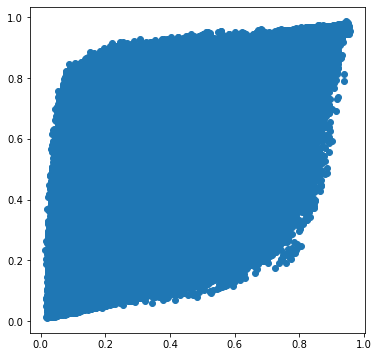

In [49]:
x_test_encoded = autoencoder.predict(x_test, batch_size=8)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], cmap='tab10')

plt.show()

In [50]:
top_10=[]

In [51]:
ooo=0

In [52]:
while ooo<10:
    top_10.append(arr[ooo])
    ooo+=1
   

In [53]:
print(top_10)

[0.63270974, 0.537898, 0.5940549, 0.56563807, 0.6052168, 0.60022324, 0.61312443, 0.5756549, 0.63466585, 0.56093925]


In [54]:
top_10=np.sort(top_10)

In [55]:
top_10=np.flip(top_10)

In [56]:
print(top_10)

[0.63466585 0.63270974 0.61312443 0.6052168  0.60022324 0.5940549
 0.5756549  0.56563807 0.56093925 0.537898  ]


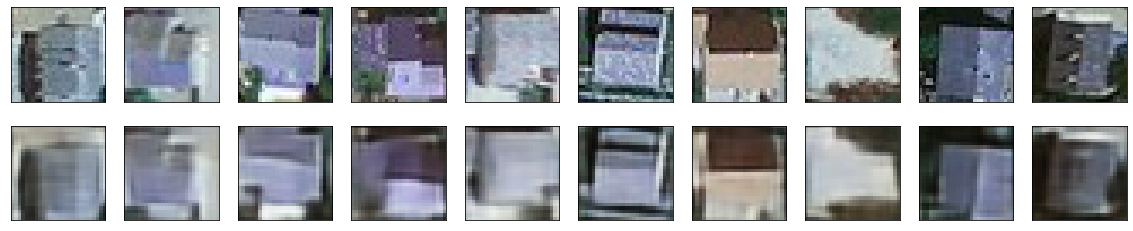

In [57]:

n=10
plt.figure(figsize=(20, 4))
for q4 in range(0, len(arr)):
    for i in range(0, n):
        if np.mean(tf.losses.binary_crossentropy(x_test[q4], decoded_imgs[q4]))==top_10[i]:
            
            
                # display original
                
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(x_test[q4].reshape(28, 28, 3))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                
                
                # display reconstruction
                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(decoded_imgs[q4].reshape(28, 28, 3))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
    
    
                

        
plt.show() 

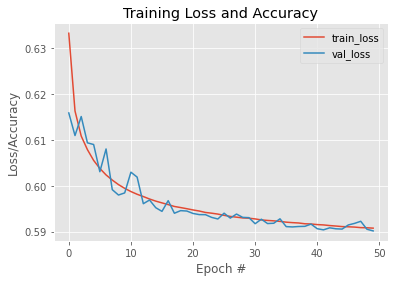

In [59]:
N = np.arange(0, 50)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H6.history["loss"], label="train_loss")
plt.plot(N, H6.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()